In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reddit/reddit_complete.csv
/kaggle/input/reddit/austin_stages.csv


In [2]:
import os
print(os.listdir("../input"))

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

['reddit']


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

from plotly import graph_objs as go
import plotly.express as px
import statsmodels.api as sm

import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

In [4]:
url =  "/content/sample_data/Austin_clean.csv"
url2 =  "/content/sample_data/reddit_2019_2022.csv"
url3 = "../input/reddit/reddit_complete.csv"#reddit_complete.csv"
url4 = "../input/reddit/austin_stages.csv" #"austin_stages.csv"
#df = pd.read_csv(url)
df = pd.read_csv(url3)
stages = pd.read_csv(url4)

In [5]:
df.head()

body        Date       id  \
0  Good god and apparently you work in software. ...  2020-05-23  frkm2w3   
1  Used to live near a Tune Up, was pretty happy ...  2020-05-23  frkm25i   
2  I hope this whole fiasco makes the general pub...  2020-05-23  frkm22r   
3       Thank you for asking the real question here.  2020-05-23  frkm1zl   
4  Restaurants can sell alcohol to go (liquor) wh...  2020-05-23  frklyq2   

    parent_id  score  polarity  subjectivity  fake_likelihood  
0  t1_frk44so    1.0  0.375000      0.475000         0.650000  
1   t3_gp9g1d    1.0  0.257273      0.780000         0.462727  
2   t3_gp9r8h    1.0  0.107500      0.429167         0.963333  
3  t1_frj5uuk    1.0  0.200000      0.300000         1.000000  
4   t3_gowk9h    1.0  0.000000      1.000000         0.500000

In [6]:
print(f"The selected data set has {df.shape[1]} columns/variables and {df.shape[0]} obervations/posts")

The selected data set has 8 columns/variables and 2136183 obervations/posts


In [7]:
#df = df[~df.apply(lambda row: row.str.contains('[removed]').any(), axis=1)]
df = df[df['body'] != '[removed]']

Checking and removing missing values

In [8]:
print(f"The selected data set has {df.shape[1]} columns/variables and {df.shape[0]} obervations/posts")

The selected data set has 8 columns/variables and 2085766 obervations/posts


**Checking for missing values**

In [9]:
df.apply(lambda x: sum(x.isnull()))

body               0
Date               0
id                 0
parent_id          0
score              0
polarity           0
subjectivity       0
fake_likelihood    0
dtype: int64

**Dropping the all the missing values from the data**

In [10]:
df= df.dropna(axis=0)
df.apply(lambda x: sum(x.isnull()))

body               0
Date               0
id                 0
parent_id          0
score              0
polarity           0
subjectivity       0
fake_likelihood    0
dtype: int64

In [11]:
stages.head()

author                                               body  \
0        helljess  Woman*. Iâ€™m sorry grown-up words and drugs o...   
1            TxEx        Fake news believers/Dan Patrick supporters.   
2      Roflattack  They won't pull you over for driving.  Don't g...   
3  insureventures             In Austin critical includes Pet shops.   
4       dyankee13                              Edibles! ðŸ”¥ðŸ”¥ðŸ”¥   

        Date       id   parent_id  score  Group    Stage  stage_num  polarity  \
0  3/24/2020  fleu096  t1_fleroki      1      6  stage 0          0   -0.0025   
1  3/24/2020  fletz0o   t3_foexxq      1      6  stage 0          0   -0.5000   
2  3/24/2020  flep3ja  t1_flel6mj      1      6  stage 0          0    0.0000   
3  3/24/2020  fleskl5   t3_fo6ynn      1      6  stage 0          0    0.0000   
4  3/24/2020  fleskkw  t1_flco8rq      1      6  stage 0          0    0.0000   

   subjectivity  fake_likelihood  
0         0.585           0.9175  
1         1.000           1.0000  
2         0.000           1.5000  
3         0.800           0.7000  
4         0.000           1.5000

In [12]:
stages.shape

(46294, 12)

## Sentimental Analysis

In sentiment analysis, polarity and subjectivity are two important aspects used to assess the sentiment expressed in a piece of text, such as a sentence or document. These aspects help classify the sentiment as positive, negative, neutral, or some degree in between. Here's what they mean:

1. Polarity:
   - Polarity refers to the emotional tone or sentiment expressed in the text. It is typically categorized into three main categories (ranging from -1 (extremely negative) to +1 (extremely positive)):
     - Positive: When the text expresses a favorable, happy, or optimistic sentiment.
     - Negative: When the text expresses an unfavorable, unhappy, or pessimistic sentiment.
     - Neutral: When the text does not express any discernible sentiment or expresses a sentiment that is neither positive nor negative.

2. Subjectivity:
   - Subjectivity measures the degree to which a piece of text is based on personal opinions, feelings, or emotions rather than objective, factual information. It is usually expressed as a numerical value between 0 and 1, where:
     - 0 indicates high objectivity: The text is very factual and does not contain personal opinions or emotions.
     - 1 indicates high subjectivity: The text is highly subjective, containing strong personal opinions, emotions, or sentiment.

Sentiment analysis models analyze text and assign a polarity label (positive, negative, or neutral) and, in some cases, a subjectivity score to help understand the emotional content and objectivity of the text. These analyses are valuable for various applications, including social media monitoring, customer feedback analysis, and product reviews, among others.

#### Extracting the most positive comments

In [13]:
# Sort the data frame by the "polarity" column in descending order
df_sorted = df.sort_values(by="polarity", ascending=False)

# Select the top 10 reviews to identify the most positive reviews
most_positive_reviews = df_sorted.head(10)

# Select the bottom 10 reviews to identify the most negative reviews
most_negative_reviews = df_sorted.tail(10)

print("Most positive reviews:")
print(most_positive_reviews)

Most positive reviews:
                                                      body        Date  \
235629                      This is the best time of year!  2020-02-26   
262706   This is so beautiful! Would you mind if KVUE s...  2020-02-08   
1251384         INaturalist is an awesome plant identifier  2021-08-01   
1139688  Listening to LOTR music and scrolled onto this...  2021-09-05   
94122    Can someone please tell me how they cooked the...  2020-04-16   
754566   DAMN what a great pic! Where was this taken at...  2019-03-14   
711788   Best combo of price and service for an oil cha...  2019-04-14   
1838637              Unintended irony is the *best* irony.  2020-11-01   
1838641                                           Awesome!  2020-11-01   
1753920              I go to Grogono as well. She’s great!  2020-12-24   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
235629   fitnikw   t3_f9set5    1.0       1.0          0.30             1.20  
2627

In [14]:
most_positive_reviews

body        Date  \
235629                      This is the best time of year!  2020-02-26   
262706   This is so beautiful! Would you mind if KVUE s...  2020-02-08   
1251384         INaturalist is an awesome plant identifier  2021-08-01   
1139688  Listening to LOTR music and scrolled onto this...  2021-09-05   
94122    Can someone please tell me how they cooked the...  2020-04-16   
754566   DAMN what a great pic! Where was this taken at...  2019-03-14   
711788   Best combo of price and service for an oil cha...  2019-04-14   
1838637              Unintended irony is the *best* irony.  2020-11-01   
1838641                                           Awesome!  2020-11-01   
1753920              I go to Grogono as well. She’s great!  2020-12-24   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
235629   fitnikw   t3_f9set5    1.0       1.0          0.30             1.20  
262706   fgxjp8h   t3_f0lz36    1.0       1.0          1.00             0.50  
1251384  h7c41cs   t3_ovvrd6    1.0       1.0          1.00             0.50  
1139688  hbr8ydk   t3_pimf3g    6.0       1.0          1.00             0.50  
94122    fnmzgef   t3_g2q4cv    1.0       1.0          0.30             1.20  
754566   eijz6ko   t3_b17wh9    1.0       1.0          0.75             0.75  
711788   ekv2qw7   t3_bczhqr   10.0       1.0          0.30             1.20  
1838637  gasubw2  t1_gaspnum    1.0       1.0          0.30             1.20  
1838641  gasu9ha  t1_gasrb5y    1.0       1.0          1.00             0.50  
1753920  ggyplnl  t1_ggyikzw    1.0       1.0          0.75             0.75

#### Extracting the most negative comments

In [15]:
print("Most negative reviews:")
print(most_negative_reviews)

Most negative reviews:
                                                      body        Date  \
667224                            That's fucking terrible.  2019-05-13   
599675              &gt; Greg Casar\n\nCasar is the worst.  2019-06-24   
432476                     Worst parking lot to exit ever.  2019-10-03   
693370                    Oh, djanga_hex. You're terrible!  2019-04-26   
1463381  And we (the city) gives tax breaks to these co...  2021-05-03   
1865711                                         Disgusting  2020-11-01   
1166356                         That place is beyond nasty  2021-08-27   
42717    Wear a mask, but don’t go to cvs on south Lama...  2020-05-05   
2039713  Im at 1061 for a 1/1 on the east side: That’s ...  2020-08-06   
786647   Thank you, Austin Antifa, for protesting this ...  2019-02-18   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
667224   endytb4   t3_boab5p   11.0      -1.0           1.0              1.5  
5996

In [16]:
most_negative_reviews

body        Date  \
667224                            That's fucking terrible.  2019-05-13   
599675              &gt; Greg Casar\n\nCasar is the worst.  2019-06-24   
432476                     Worst parking lot to exit ever.  2019-10-03   
693370                    Oh, djanga_hex. You're terrible!  2019-04-26   
1463381  And we (the city) gives tax breaks to these co...  2021-05-03   
1865711                                         Disgusting  2020-11-01   
1166356                         That place is beyond nasty  2021-08-27   
42717    Wear a mask, but don’t go to cvs on south Lama...  2020-05-05   
2039713  Im at 1061 for a 1/1 on the east side: That’s ...  2020-08-06   
786647   Thank you, Austin Antifa, for protesting this ...  2019-02-18   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
667224   endytb4   t3_boab5p   11.0      -1.0           1.0              1.5  
599675   erxmfix  t1_erxjiyp    6.0      -1.0           1.0              1.5  
432476   f2cogzg  t1_f2bi65k    1.0      -1.0           1.0              1.5  
693370   elut5zo  t1_eluoiyn    1.0      -1.0           1.0              1.5  
1463381  gwu08x5  t1_gwtrcqq    6.0      -1.0           1.0              1.5  
1865711  gauwh79   t3_jm84og    1.0      -1.0           1.0              1.5  
1166356  haleuec  t1_haleqrc    0.0      -1.0           1.0              1.5  
42717    fpmiqnw   t3_ge3wh3    1.0      -1.0           1.0              1.5  
2039713  g0lqj2w   t3_i4vodl    1.0      -1.0           1.0              1.5  
786647   egqz818   t3_as0w0g    1.0      -1.0           0.8              1.7

#### Identifying possibly fake post

The code below aims to identify reviews that are most likely to be fake by calculating a "fake likelihood" score based on the polarity and subjectivity of each review. Here's a breakdown of what this code does:

1. **Create a New Column "fake_likelihood":**
   - It adds a new column called "fake_likelihood" to the DataFrame `df` and initializes all its values to 0.

2. **Calculate the "fake_likelihood" Score for Each Review:**
   - It iterates through each row in the DataFrame using a `for` loop and `df.iterrows()`.
   - For each row, it retrieves the "polarity" and "subjectivity" values, which presumably represent sentiment analysis results for a review.
   - It calculates the "fake_likelihood" score for that review by taking the absolute difference between the polarity and 0.5 (a measure of how far the sentiment is from neutral) and the absolute difference between subjectivity and 1 (a measure of how subjective the text is). The sum of these differences is used to compute the "fake_likelihood" score.
   - It updates the "fake_likelihood" column in the DataFrame with the computed value for each review using `df.loc[]`.

3. **Sort the DataFrame by "fake_likelihood":**
   - After calculating the "fake_likelihood" scores for all reviews, the code sorts the DataFrame in descending order based on the "fake_likelihood" column. This means that reviews with higher "fake_likelihood" scores will appear at the top.

4. **Select the Top 10 Most Likely Fake Reviews:**
   - The code then selects the top 10 reviews with the highest "fake_likelihood" scores using `df_sorted.head(10)` and stores them in the `most_likely_fake_reviews` DataFrame.

5. **Print the Results:**
   - Finally, the code prints a message to indicate that it is displaying reviews that are most likely to be fake and then prints the `most_likely_fake_reviews` DataFrame, which contains these reviews.

The "fake_likelihood" score is essentially a measure of how far the sentiment and subjectivity of a review are from what might be expected in a genuine, non-biased review. Reviews with higher "fake_likelihood" scores are considered more likely to be fake or less trustworthy. This code helps to identify and prioritize such reviews for further analysis or investigation.

In [17]:
# Sort the data frame by the "fake_likelihood" column in descending order
df_sorted = df.sort_values(by="fake_likelihood", ascending=False)

# Select the top 10 reviews to identify the reviews that are most likely to be fake
most_likely_fake_reviews = df_sorted.head(10)

print("Reviews that are most likely to be fake:")
print(most_likely_fake_reviews)

Reviews that are most likely to be fake:
                                                      body        Date  \
1471882  THERE IS NOT TOO MUCH ANGER!!!! HOW DARE YOU!!...  2021-05-01   
1254474  Umm I don't like this. I can't use this mindse...  2021-07-31   
1178330  But the voters complained to the manager with ...  2021-08-23   
143729   bodega. corner store. convenience store. i’ve ...  2020-03-28   
1060476  I agree with ya, I have a love/hate relationsh...  2021-10-09   
706729                   Never! J/k. It wasn’t real grief.  2019-04-17   
1060887                  You have real anger issues, dude.  2021-10-09   
1384515  One of the reasons I'm so frustrated is becaus...  2021-06-08   
292251   Now I’m frustrated with myself for never check...  2020-01-18   
1543991            To anger management you go! Goose fraba  2021-03-29   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
1471882  gwjmczn  t1_gwjm6lh    0.0 -1.000000          0.20      

In [18]:
most_likely_fake_reviews

body        Date  \
1471882  THERE IS NOT TOO MUCH ANGER!!!! HOW DARE YOU!!...  2021-05-01   
1254474  Umm I don't like this. I can't use this mindse...  2021-07-31   
1178330  But the voters complained to the manager with ...  2021-08-23   
143729   bodega. corner store. convenience store. i’ve ...  2020-03-28   
1060476  I agree with ya, I have a love/hate relationsh...  2021-10-09   
706729                   Never! J/k. It wasn’t real grief.  2019-04-17   
1060887                  You have real anger issues, dude.  2021-10-09   
1384515  One of the reasons I'm so frustrated is becaus...  2021-06-08   
292251   Now I’m frustrated with myself for never check...  2020-01-18   
1543991            To anger management you go! Goose fraba  2021-03-29   

              id   parent_id  score  polarity  subjectivity  fake_likelihood  
1471882  gwjmczn  t1_gwjm6lh    0.0 -1.000000          0.20         2.300000  
1254474  h76bd7u  t1_h74zk83    1.0 -1.000000          0.20         2.300000  
1178330  ha1qyu7  t1_ha1faza    4.0 -0.915527          0.20         2.215527  
143729   flshaly  t1_flrre87    1.0 -0.762939          0.05         2.212939  
1060476  hg1fxen   t3_q4vv7c    2.0 -1.000000          0.30         2.200000  
706729   el3sm3l  t1_el3sdhd    1.0 -1.000000          0.30         2.200000  
1060887  hg0im2w  t1_hfze6vu    1.0 -1.000000          0.30         2.200000  
1384515  h10ysvg  t1_h10w4kn   13.0 -0.875000          0.20         2.175000  
292251   feu20e0  t1_fery58e    1.0 -0.875000          0.20         2.175000  
1543991  gsr70p3  t1_gsp9h33    1.0 -0.875000          0.20         2.175000

#### Basic statistics on sentiments, subjectivity and fake_likelihood

In [19]:
df[["polarity"]].describe()

polarity
count  2.085766e+06
mean   8.055294e-02
std    2.659678e-01
min   -1.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    2.000000e-01
max    1.000000e+00

A quick review of these summary statistics reveals the following insights.

- The min value is -1.0, which indicates the polarity or intensity of the most negative response is strongly negative (range of sentiment polarity score is -1 to +1)
- The max value is +1.0, which indicates the polarity or intensity of the most positive response is highly positive (range of sentiment polarity score is -1 to +1)
- The mean value is +0.075892 which indicates the average polarity or intensity of sentiment across all responses is in the very neutral.

In [20]:
df[["subjectivity"]].describe()

subjectivity
count  2.085766e+06
mean   3.838701e-01
std    2.990303e-01
min    0.000000e+00
25%    0.000000e+00
50%    4.166667e-01
75%    6.000000e-01
max    1.000000e+00

A quick review of these summary statistics reveals the following insights.

- The min value is 0.0, which indicates a very objective opinion
- The max value is +1.0, which indicates a very subjective opinion
- The mean value is +0.03748 which indicates the objectivity in the comments of people overall.

In [21]:
df[["fake_likelihood"]].describe()

fake_likelihood
count     2.085766e+06
mean      1.060805e+00
std       3.857287e-01
min       0.000000e+00
25%       7.777778e-01
50%       1.075000e+00
75%       1.500000e+00
max       2.300000e+00

### Data splitting

First of all, splitting the dataset into a training and a testing set. The test set is the 10% of the original dataset. For this particular analysis I dropped the neutral tweets, as my goal was to only differentiate positive and negative tweets.

In [22]:
# Splitting the dataset into train and test set
train_1, test_1 = train_test_split(df,test_size = 0.3)
# Removing neutral sentiments
#train = train[train.sentiment != "Neutral"]

- As a next step we separated the Positive and Negative tweets of the training set in order to easily visualize their contained words. After that I cleaned the text from hashtags, mentions and links. Now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

- Grouping the sentiments as either positive or negative based on their polarity score.

In [23]:
train_pos = df[ df['polarity'] >= 0.5]
train_pos = train_pos['body']
train_neg = df[ df['polarity'] <= -0.5]
train_neg = train_neg['body']

In [24]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

#### Positive words

Positive words


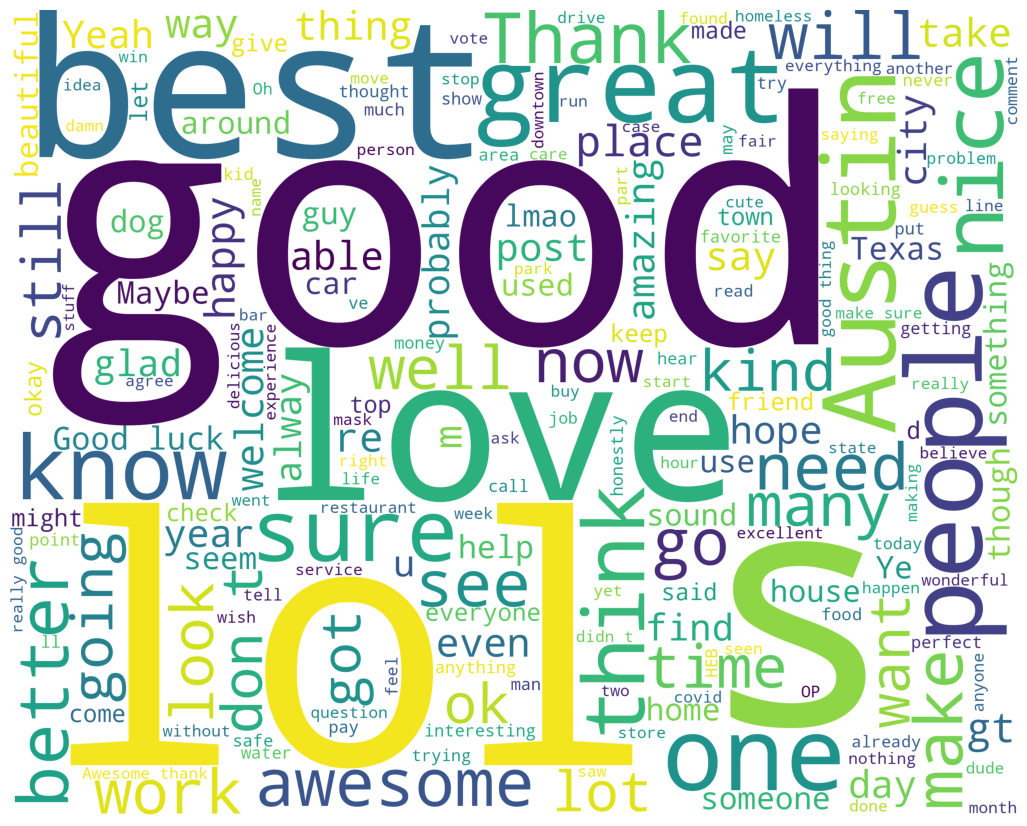

In [25]:
print("Positive words")
wordcloud_draw(train_pos,'white')

In [26]:
train_pos_1 = train_1[ train_1['polarity'] >= 0.5]
train_pos_1 = train_pos_1['body']
train_neg_1 = test_1[ test_1['polarity'] <= -0.5]
train_neg_1 = train_neg_1['body']

Positive words


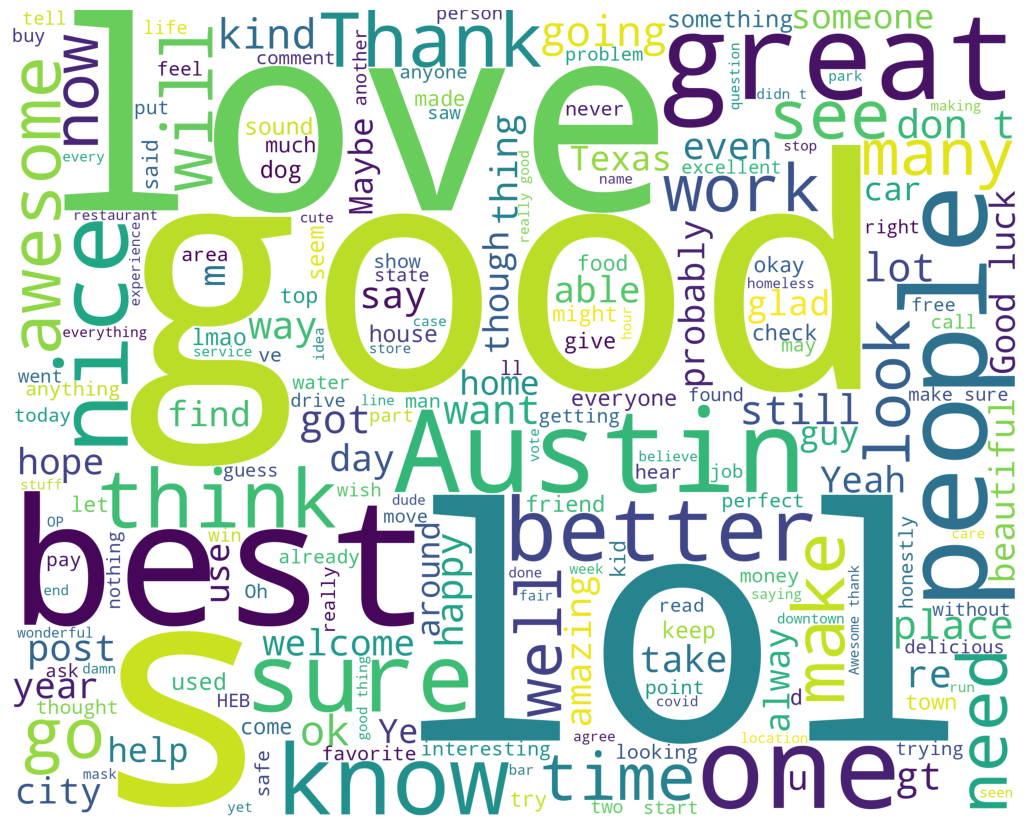

In [27]:
print("Positive words")
wordcloud_draw(train_pos_1,'white')

#### Negative words

Negative words


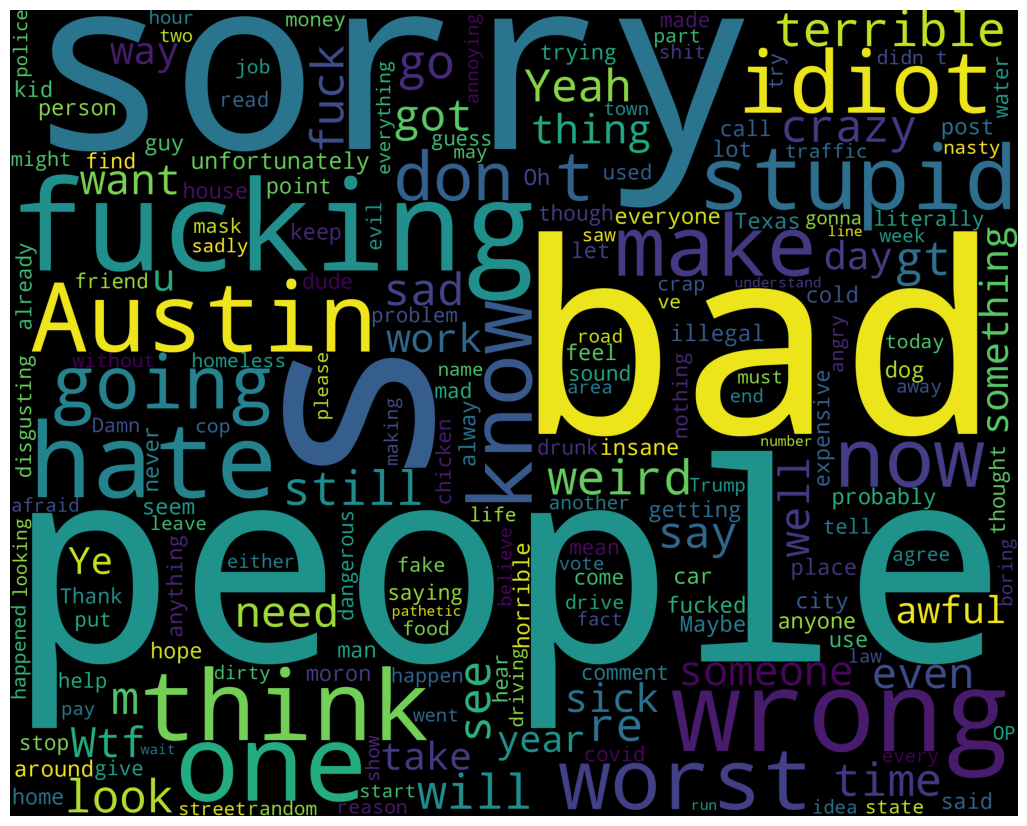

In [28]:
print("Negative words")
wordcloud_draw(train_neg)

In [29]:
print("Negative words")
wordcloud_draw(train_neg_1)

Negative words


After the vizualization, I removed the hashtags, mentions, links and stopwords from the training set.

**Stop Word:** Stop Words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return vast amount of unnecessary information. ( the, for, this etc. )

In [30]:
tweets = []
import nltk
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

for index, row in df.iterrows():
    words_filtered = [e.lower() for e in row.body.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.polarity))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As a next step we extracted the so called features with nltk lib, first by measuring a frequent distribution and by selecting the resulting keys.

In [31]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

Hereby I plotted the most frequently distributed words. The most words are centered around debate nights.


In [32]:
wordcloud_draw(w_features)

#### Most frequent positive words

In [33]:
train_pos_1 = df[ df['polarity'] >= 0.5]

In [34]:
pos_tweets = []
import nltk
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

for index, row in train_pos_1.iterrows():
    words_filtered = [e.lower() for e in row.body.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    pos_tweets.append((words_without_stopwords, row.polarity))
    
    
    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Extracting word features
def get_words_in_tweets(pos_tweets):
    all = []
    for (words, sentiment) in pos_tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features_pos = get_word_features(get_words_in_tweets(pos_tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features_pos:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [36]:
print("Positive words")
wordcloud_draw(w_features_pos,'white')

Positive words


#### Most frequent positive words

In [37]:
train_neg_1 = df[ df['polarity'] <= -0.5]

neg_tweets = []
import nltk
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))

for index, row in train_neg_1.iterrows():
    words_filtered_n = [e.lower() for e in row.body.split() if len(e) >= 3]
    words_cleaned_n = [word for word in words_filtered_n
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords_n = [word for word in words_cleaned_n if not word in stopwords_set]
    neg_tweets.append((words_without_stopwords_n, row.polarity))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Extracting word features
def get_words_in_tweets(neg_tweets):
    all = []
    for (words, sentiment) in neg_tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features_neg = get_word_features(get_words_in_tweets(neg_tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features_neg:
        features['contains(%s)' % word] = (word in document_words)
    return features

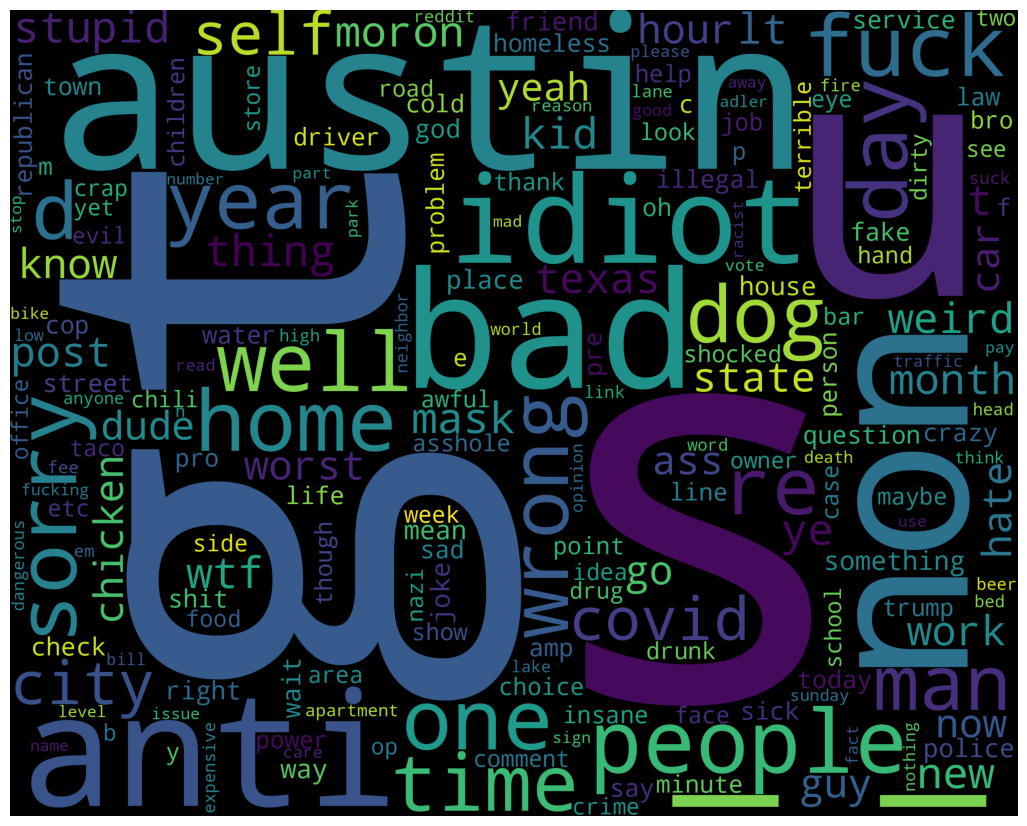

In [39]:
wordcloud_draw(w_features_neg)

### Sentiments over time

#### For the entire data set

In [40]:
df_cp = df.copy()
df_cp['Date'] = pd.to_datetime(df_cp['Date'])
df_cp['YearMonth'] = df_cp['Date'].dt.strftime('%Y-%m')

df_cp.head()

body       Date       id  \
0  Good god and apparently you work in software. ... 2020-05-23  frkm2w3   
1  Used to live near a Tune Up, was pretty happy ... 2020-05-23  frkm25i   
2  I hope this whole fiasco makes the general pub... 2020-05-23  frkm22r   
3       Thank you for asking the real question here. 2020-05-23  frkm1zl   
4  Restaurants can sell alcohol to go (liquor) wh... 2020-05-23  frklyq2   

    parent_id  score  polarity  subjectivity  fake_likelihood YearMonth  
0  t1_frk44so    1.0  0.375000      0.475000         0.650000   2020-05  
1   t3_gp9g1d    1.0  0.257273      0.780000         0.462727   2020-05  
2   t3_gp9r8h    1.0  0.107500      0.429167         0.963333   2020-05  
3  t1_frj5uuk    1.0  0.200000      0.300000         1.000000   2020-05  
4   t3_gowk9h    1.0  0.000000      1.000000         0.500000   2020-05

<Axes: title={'center': 'Sentiment Score'}, xlabel='Period', ylabel='Mean Sentiment Score'>

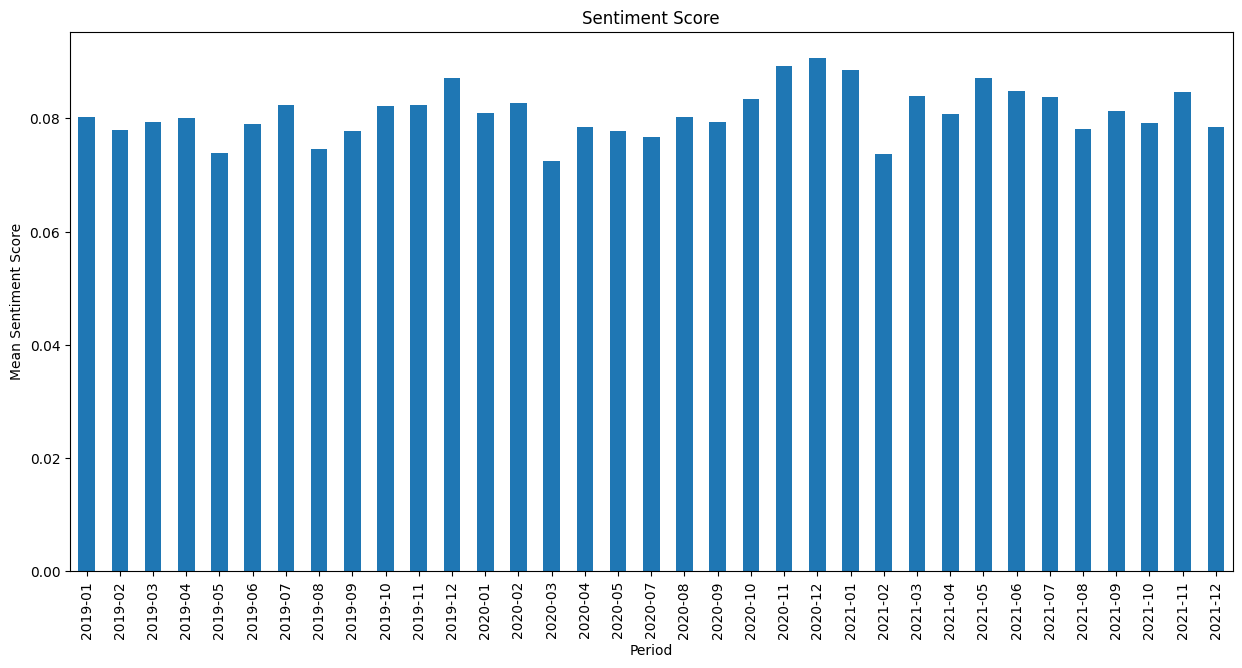

In [41]:
# generate mean of sentiment_score by period

dfg = df_cp.groupby(['YearMonth'])['polarity'].mean()

#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(15, 7))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, '2020-05'),
  Text(1, 0, '2020-04'),
  Text(2, 0, '2020-03'),
  Text(3, 0, '2020-02'),
  Text(4, 0, '2020-01'),
  Text(5, 0, '2019-12'),
  Text(6, 0, '2019-11'),
  Text(7, 0, '2019-10'),
  Text(8, 0, '2019-09'),
  Text(9, 0, '2019-08'),
  Text(10, 0, '2019-07'),
  Text(11, 0, '2019-06'),
  Text(12, 0, '2019-05'),
  Text(13, 0, '2019-04'),
  Text(14, 0, '2019-03'),
  Text(15, 0, '2019-02'),
  Text(16, 0, '2019-01'),
  Text(17, 0, '2021-12'),
  Text(18, 0, '2021-11'),
  Text(19, 0, '2021-10'),
  Text(20, 0, '2021-09'),
  Text(21, 0, '2021-08'),
  Text(22, 0, '2021-07'),
  Text(23, 0, '2021-06'),
  Text(24, 0, '2021-05'),
  Text(25, 0, '2021-04'),
  Text(26, 0, '2021-03'),
  Text(27, 0, '2021-02'),
  Text(28, 0, '2021-01'),
  Text(29, 0, '2020-12'),
  Text(30, 0, '2020-11'),
  Text(31, 0, '2020-10'),
  Text(32, 0

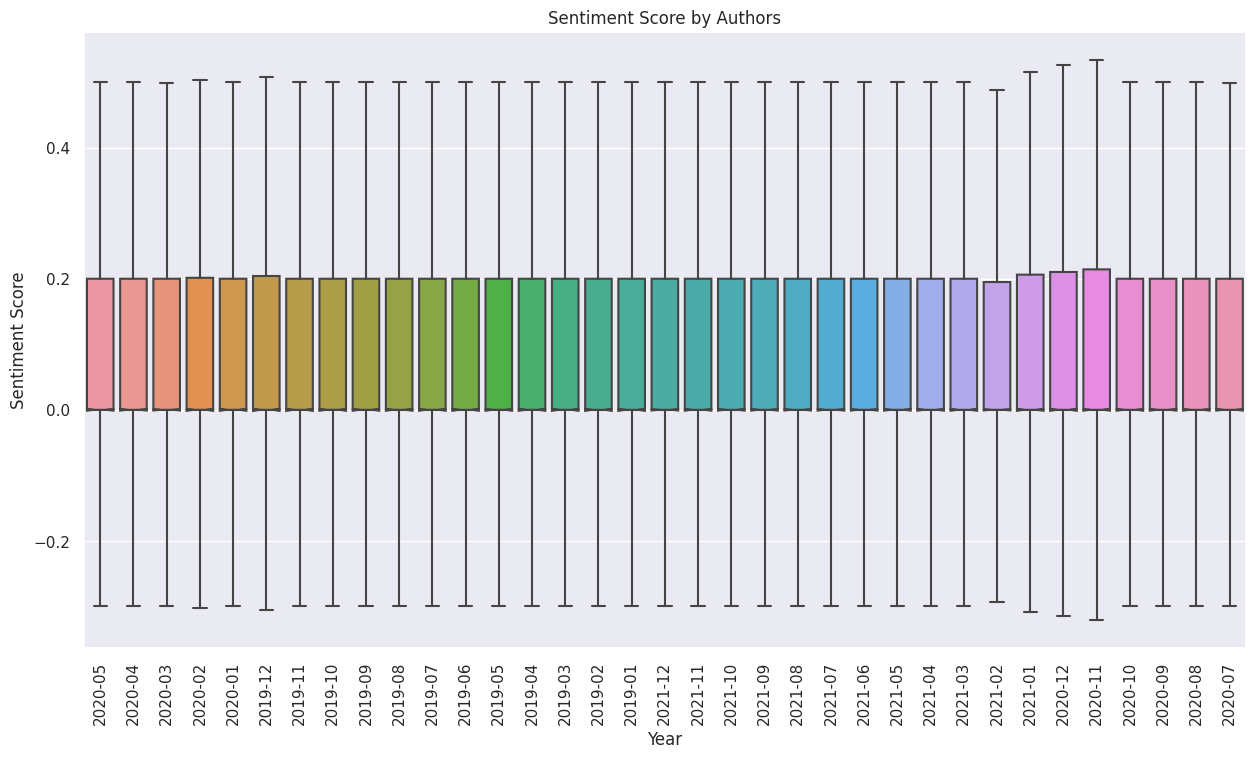

In [42]:
import seaborn as sns
#create seaborn boxplots by group
sns.set(rc={"figure.figsize":(15, 8)})
sns.boxplot(x='YearMonth', y='polarity', notch = True,
            data=df_cp, showfliers=False).set(title='Sentiment Score by Authors')
#modify axis labels
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)

#### For the stages data set

In [43]:
stages_cp = stages.copy()
stages_cp['Date'] = pd.to_datetime(stages_cp['Date'])
stages_cp['YearMonth'] = stages_cp['Date'].dt.strftime('%Y-%m')

In [44]:
stages_cp.head()

author                                               body  \
0        helljess  Woman*. Iâ€™m sorry grown-up words and drugs o...   
1            TxEx        Fake news believers/Dan Patrick supporters.   
2      Roflattack  They won't pull you over for driving.  Don't g...   
3  insureventures             In Austin critical includes Pet shops.   
4       dyankee13                              Edibles! ðŸ”¥ðŸ”¥ðŸ”¥   

        Date       id   parent_id  score  Group    Stage  stage_num  polarity  \
0 2020-03-24  fleu096  t1_fleroki      1      6  stage 0          0   -0.0025   
1 2020-03-24  fletz0o   t3_foexxq      1      6  stage 0          0   -0.5000   
2 2020-03-24  flep3ja  t1_flel6mj      1      6  stage 0          0    0.0000   
3 2020-03-24  fleskl5   t3_fo6ynn      1      6  stage 0          0    0.0000   
4 2020-03-24  fleskkw  t1_flco8rq      1      6  stage 0          0    0.0000   

   subjectivity  fake_likelihood YearMonth  
0         0.585           0.9175   2020-03  
1         1.000           1.0000   2020-03  
2         0.000           1.5000   2020-03  
3         0.800           0.7000   2020-03  
4         0.000           1.5000   2020-03

In [45]:
#generate mean of sentiment_score by period
dfg = stages_cp.groupby(['YearMonth'])['polarity'].mean()

#create a bar plot
dfg.plot(kind='bar', title='Sentiment Score for staged data', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(15, 7))

<Axes: title={'center': 'Sentiment Score for staged data'}, xlabel='Period', ylabel='Mean Sentiment Score'>

<Axes: title={'center': 'Sentiment Score for stages data'}, xlabel='Stages', ylabel='Mean Sentiment Score'>

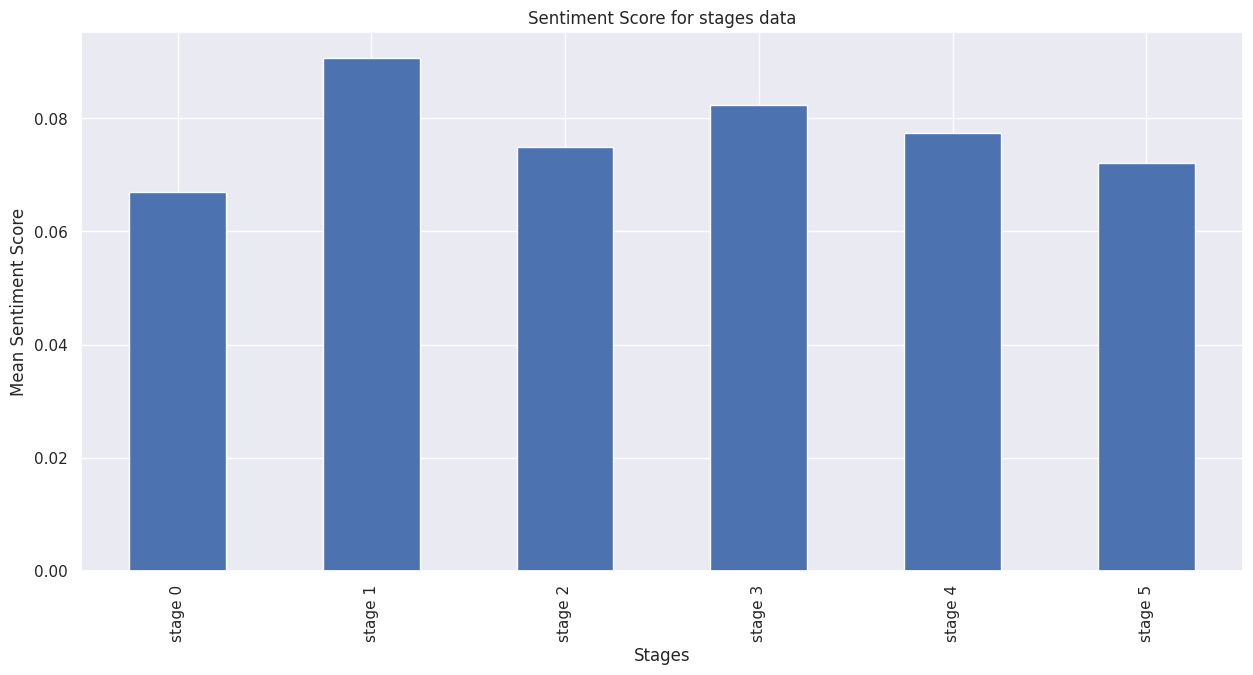

In [46]:
#generate mean of sentiment_score by period
dfg1 = stages_cp.groupby(['Stage'])['polarity'].mean()

#create a bar plot
dfg1.plot(kind='bar', title='Sentiment Score for stages data', ylabel='Mean Sentiment Score',
         xlabel='Stages', figsize=(15, 7))

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'stage 0'),
  Text(1, 0, 'stage 1'),
  Text(2, 0, 'stage 2'),
  Text(3, 0, 'stage 3'),
  Text(4, 0, 'stage 4'),
  Text(5, 0, 'stage 5')])

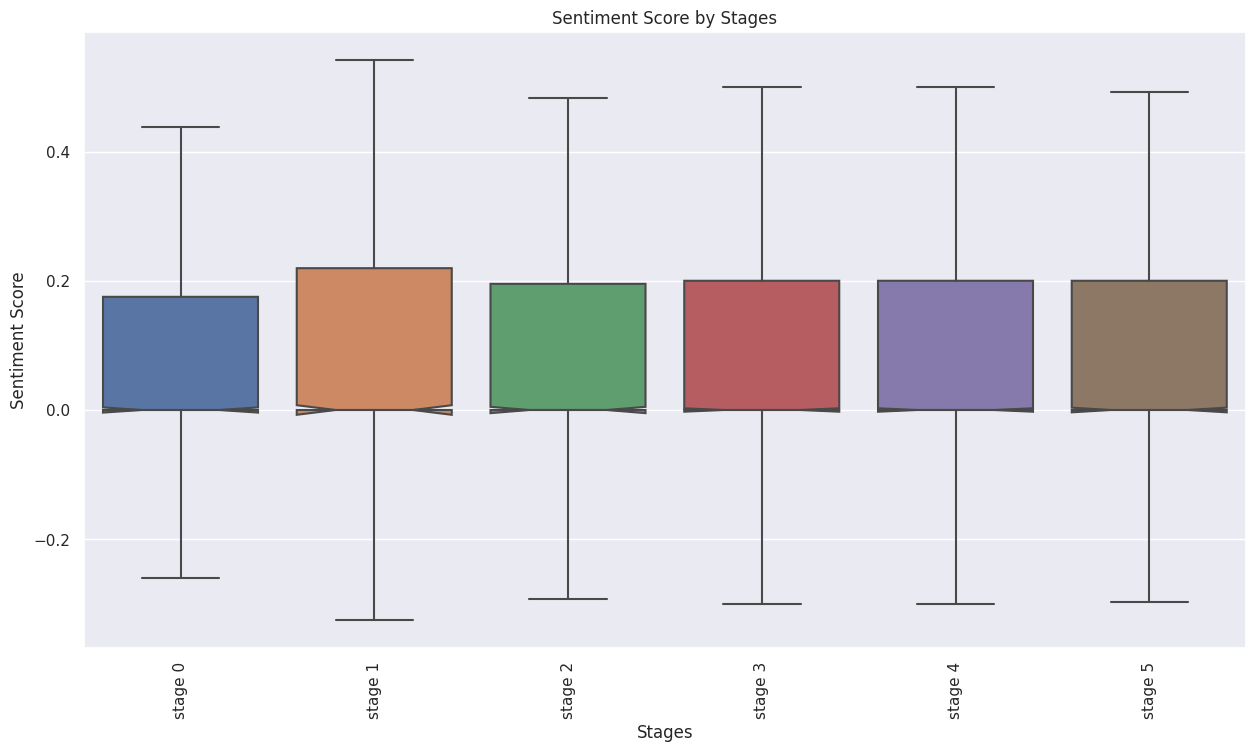

In [47]:
import seaborn as sns
#create seaborn boxplots by group
sns.set(rc={"figure.figsize":(15, 8)})
sns.boxplot(x='Stage', y='polarity', notch = True,
            data=stages_cp, showfliers=False).set(title='Sentiment Score by Stages')
#modify axis labels
plt.xlabel('Stages')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)

## How subjective were people over time

In [48]:
import seaborn as sns
#create seaborn boxplots by group
sns.set(rc={"figure.figsize":(15, 8)})
sns.boxplot(x='YearMonth', y='subjectivity', notch = True,
            data=df_cp, showfliers=False).set(title='Subjectivity Score by Authors')
#modify axis labels
plt.xlabel('Year')
plt.ylabel('Subjectivity Score')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, '2020-05'),
  Text(1, 0, '2020-04'),
  Text(2, 0, '2020-03'),
  Text(3, 0, '2020-02'),
  Text(4, 0, '2020-01'),
  Text(5, 0, '2019-12'),
  Text(6, 0, '2019-11'),
  Text(7, 0, '2019-10'),
  Text(8, 0, '2019-09'),
  Text(9, 0, '2019-08'),
  Text(10, 0, '2019-07'),
  Text(11, 0, '2019-06'),
  Text(12, 0, '2019-05'),
  Text(13, 0, '2019-04'),
  Text(14, 0, '2019-03'),
  Text(15, 0, '2019-02'),
  Text(16, 0, '2019-01'),
  Text(17, 0, '2021-12'),
  Text(18, 0, '2021-11'),
  Text(19, 0, '2021-10'),
  Text(20, 0, '2021-09'),
  Text(21, 0, '2021-08'),
  Text(22, 0, '2021-07'),
  Text(23, 0, '2021-06'),
  Text(24, 0, '2021-05'),
  Text(25, 0, '2021-04'),
  Text(26, 0, '2021-03'),
  Text(27, 0, '2021-02'),
  Text(28, 0, '2021-01'),
  Text(29, 0, '2020-12'),
  Text(30, 0, '2020-11'),
  Text(31, 0, '2020-10'),
  Text(32, 0

In [49]:
# generate mean of sentiment_score by period

dfg_sub = df_cp.groupby(['YearMonth'])['subjectivity'].mean()

#create a bar plot
dfg_sub.plot(kind='bar', title='Subjectivity', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(15, 7))

<Axes: title={'center': 'Subjectivity'}, xlabel='Period', ylabel='Mean Sentiment Score'>

In [50]:
import seaborn as sns
#create seaborn boxplots by s6tage
sns.set(rc={"figure.figsize":(15, 8)})
sns.boxplot(x='YearMonth', y='subjectivity', notch = True,
            data=stages_cp, showfliers=False).set(title='Subjectivity Score by Authors')
#modify axis labels
plt.xlabel('Year')
plt.ylabel('Subjectivity Score')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '2020-03'),
  Text(1, 0, '2020-04'),
  Text(2, 0, '2021-05'),
  Text(3, 0, '2020-05'),
  Text(4, 0, '2020-07'),
  Text(5, 0, '2020-08'),
  Text(6, 0, '2020-10'),
  Text(7, 0, '2021-03'),
  Text(8, 0, '2020-02'),
  Text(9, 0, '2020-09'),
  Text(10, 0, '2020-11'),
  Text(11, 0, '2021-12'),
  Text(12, 0, '2020-01'),
  Text(13, 0, '2020-12')])

In [51]:
import seaborn as sns
#create seaborn boxplots by s6tage
sns.set(rc={"figure.figsize":(15, 8)})
sns.boxplot(x='Stage', y='subjectivity', notch = True,
            data=stages_cp, showfliers=False).set(title='Subjectivity Score by Authors')
#modify axis labels
plt.xlabel('Year')
plt.ylabel('Subjectivity Score')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'stage 0'),
  Text(1, 0, 'stage 1'),
  Text(2, 0, 'stage 2'),
  Text(3, 0, 'stage 3'),
  Text(4, 0, 'stage 4'),
  Text(5, 0, 'stage 5')])

In [52]:
# generate mean of subjective_score by stage

dfg_sub = stages_cp.groupby(['Stage'])['subjectivity'].mean()

#create a bar plot
dfg_sub.plot(kind='bar', title='Subjectivity', ylabel='Mean Sentiment Score',
         xlabel='Period', figsize=(15, 7))

<Axes: title={'center': 'Subjectivity'}, xlabel='Period', ylabel='Mean Sentiment Score'>

## Time series plot

#### For general data

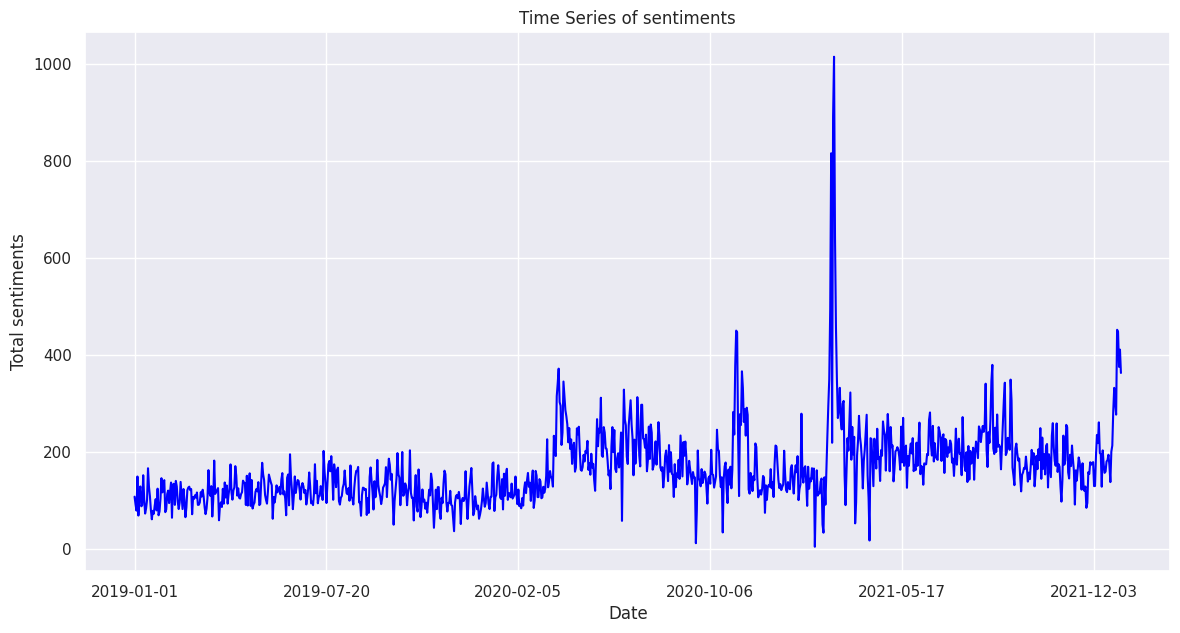

In [53]:
# Aggregate scores by date
time_series = df.groupby('Date')['polarity'].sum()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of sentiments', color='blue')
plt.xlabel('Date')
plt.ylabel('Total sentiments')
plt.grid(True)
plt.show()

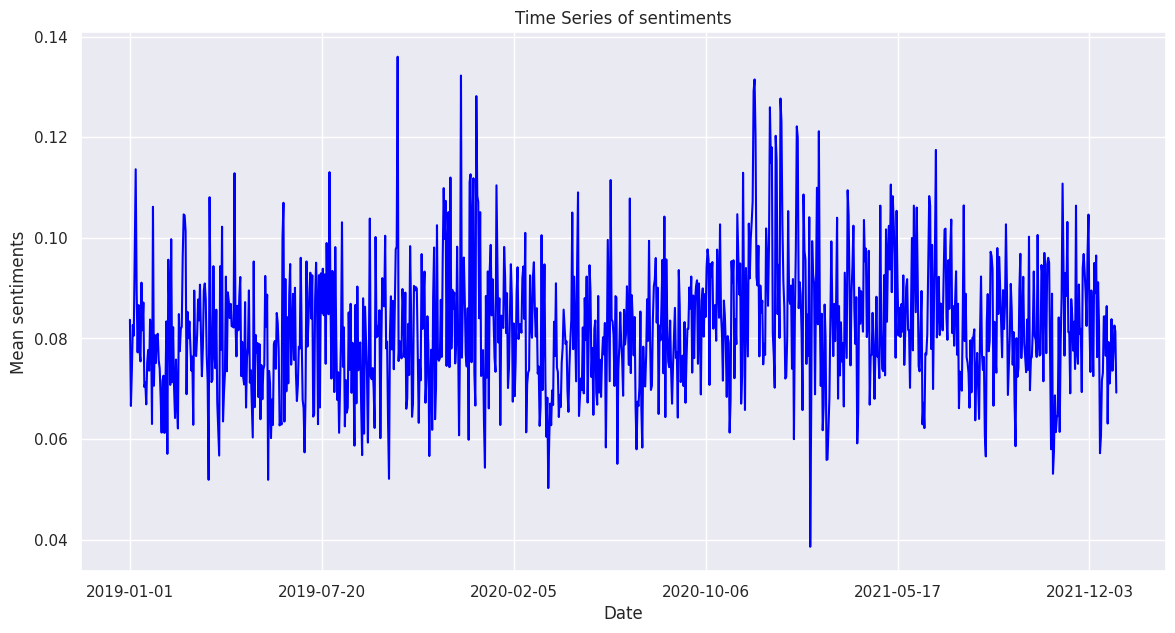

In [54]:
# Aggregate scores by date
time_series = df.groupby('Date')['polarity'].mean()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of sentiments', color='blue')
plt.xlabel('Date')
plt.ylabel('Mean sentiments')
plt.grid(True)
plt.show()

#### For stages

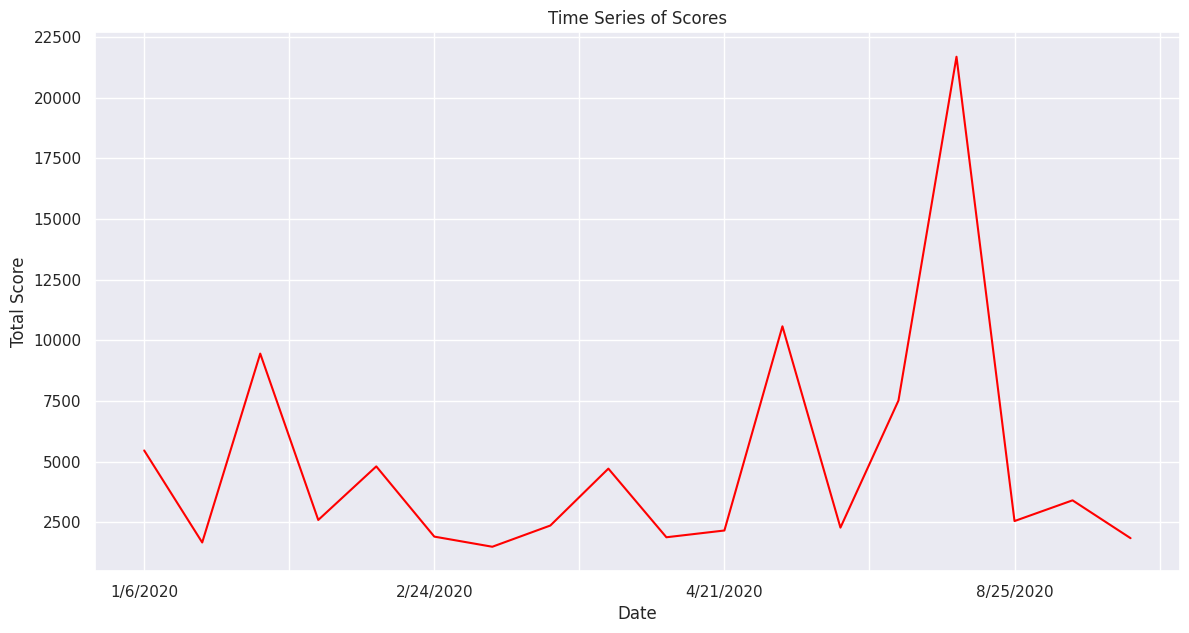

In [55]:
# Aggregate scores by date
time_series = stages.groupby('Date')['score'].sum()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Scores', color='red')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.grid(True)
plt.show()

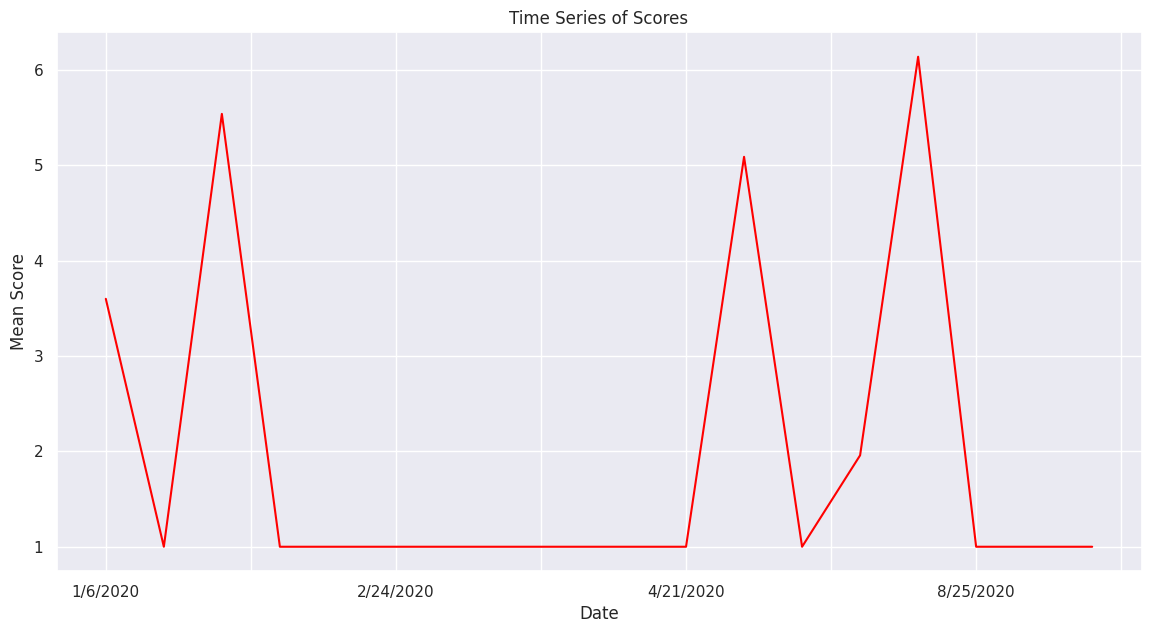

In [56]:
# Aggregate scores by date
time_series = stages.groupby('Date')['score'].mean()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Scores', color='red')
plt.xlabel('Date')
plt.ylabel('Mean Score')
plt.grid(True)
plt.show()

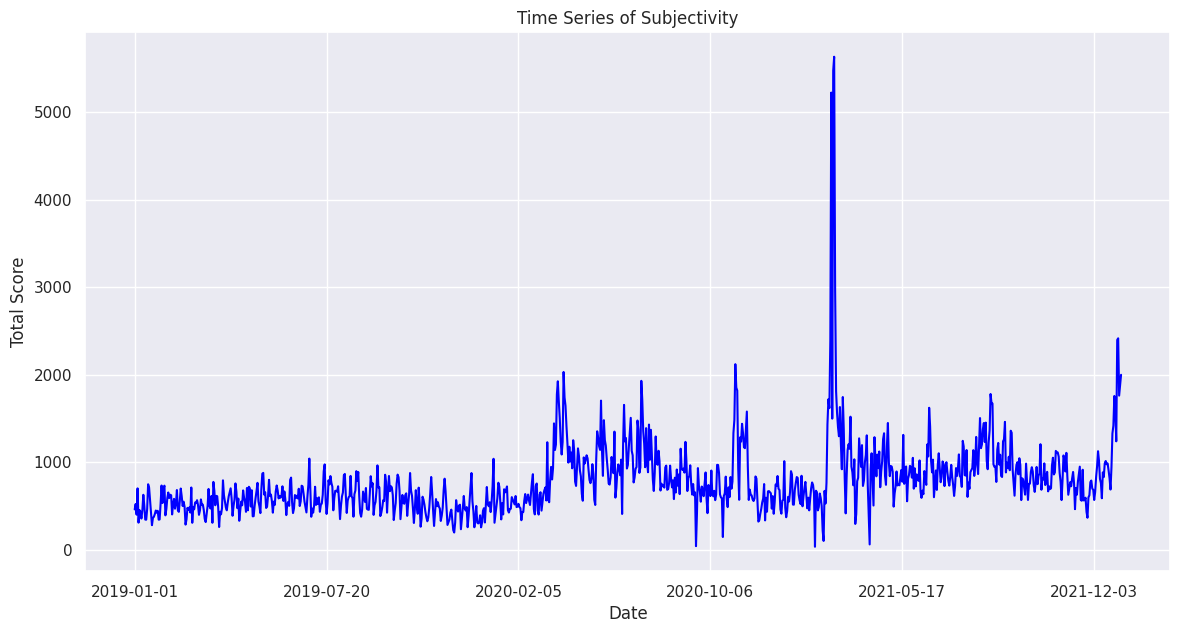

In [57]:
# Aggregate scores by date
time_series = df.groupby('Date')['subjectivity'].sum()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Subjectivity', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.grid(True)
plt.show()

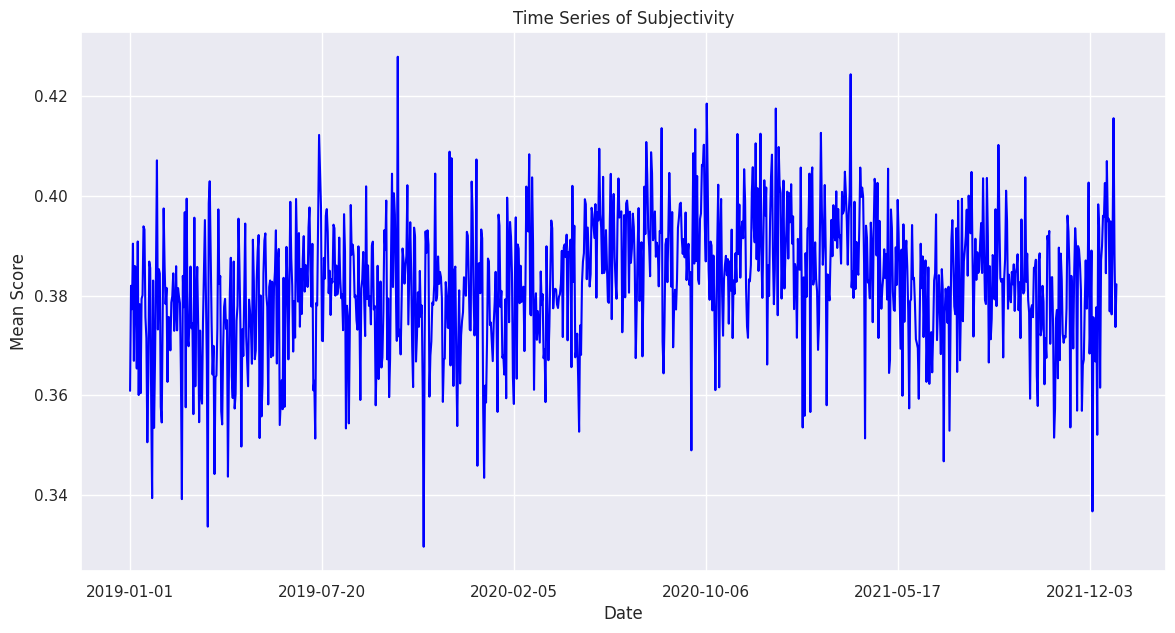

In [58]:
# Aggregate scores by date
time_series = df.groupby('Date')['subjectivity'].mean()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Subjectivity', color='blue')
plt.xlabel('Date')
plt.ylabel('Mean Score')
plt.grid(True)
plt.show()

#### For stages (subjectivity)

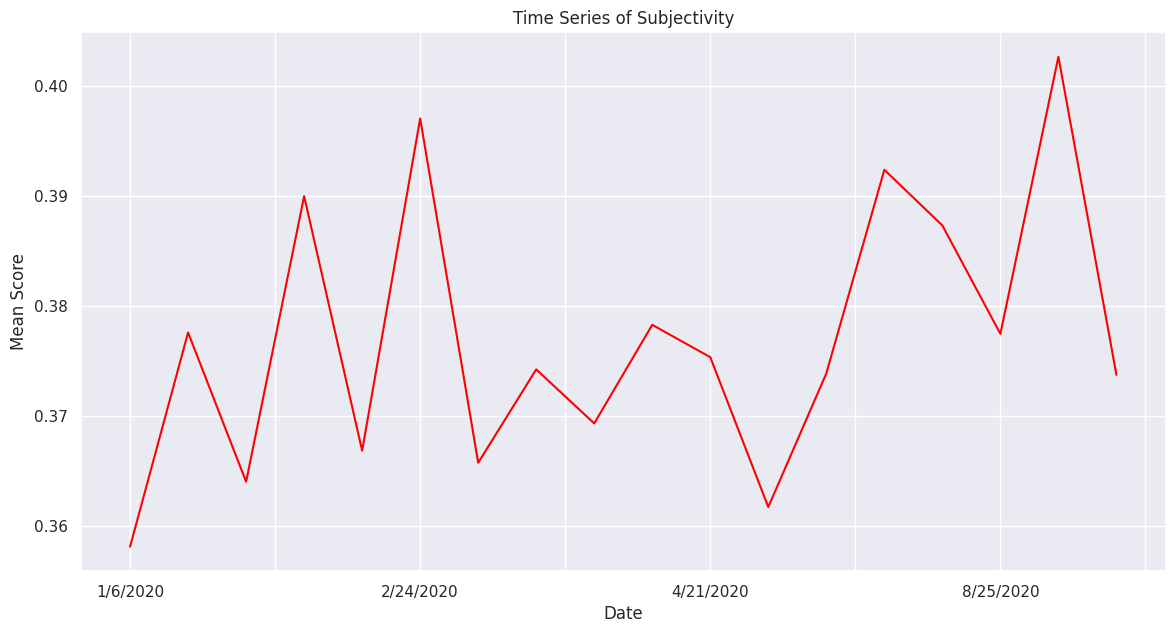

In [59]:
# Aggregate scores by date
time_series = stages.groupby('Date')['subjectivity'].mean()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Subjectivity', color='red')
plt.xlabel('Date')
plt.ylabel('Mean Score')
plt.grid(True)
plt.show()

In [60]:
# Aggregate scores by date
time_series = stages.groupby('Date')['subjectivity'].sum()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Subjectivity', color='red')
plt.xlabel('Date')
plt.ylabel('Mean Score')
plt.grid(True)
plt.show()

### Distribution of user replies to Parent Comments

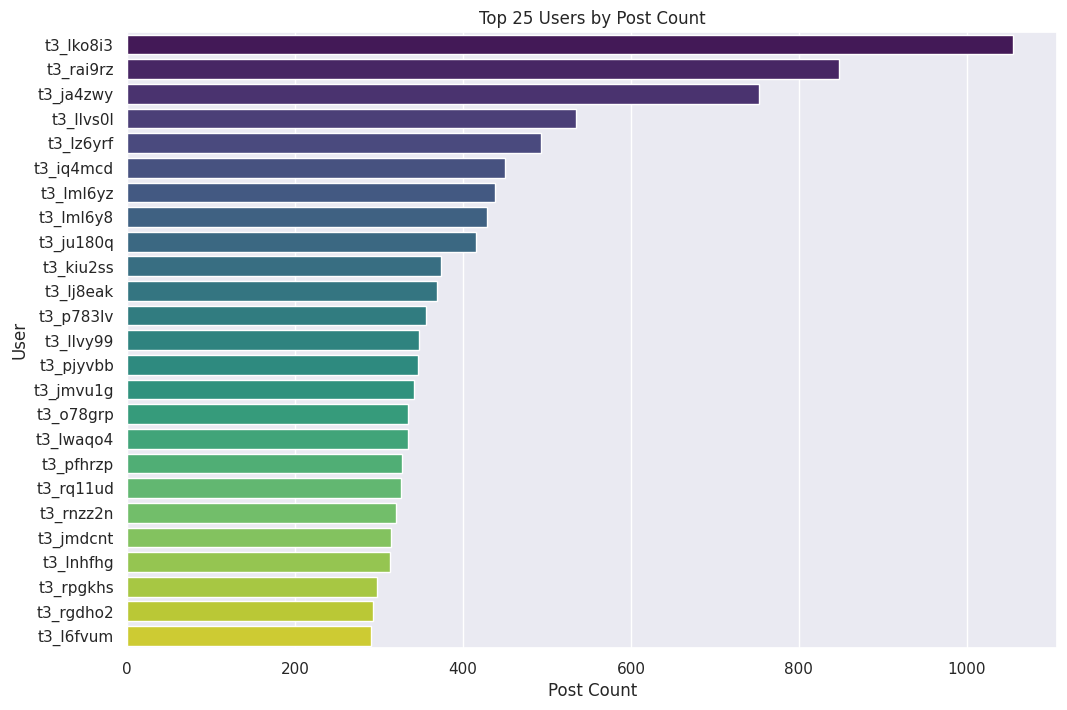

In [61]:
#  Distribution of user replies to Parent Comments
user_counts = df['parent_id'].value_counts().head(25)

plt.figure(figsize=(12, 8))
sns.barplot(x=user_counts.values, y=user_counts.index, palette='viridis')
plt.title('Top 25 Users by Post Count')
plt.xlabel('Post Count')
plt.ylabel('User')
plt.show()

### Distribution of post length

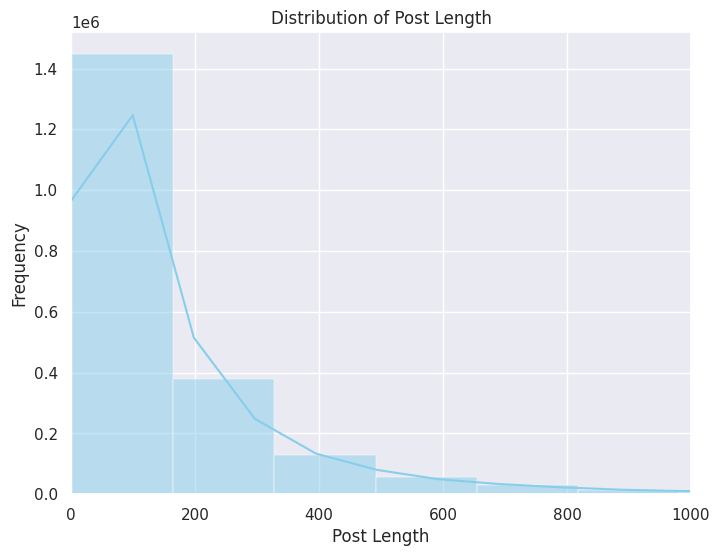

In [62]:
#  Post Length Distribution
df_s = df.copy()
df_s['post_length'] = df_s['body'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(data=df_s, x='post_length', bins=120, kde=True, color='skyblue')
plt.title('Distribution of Post Length')
plt.xlabel('Post Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

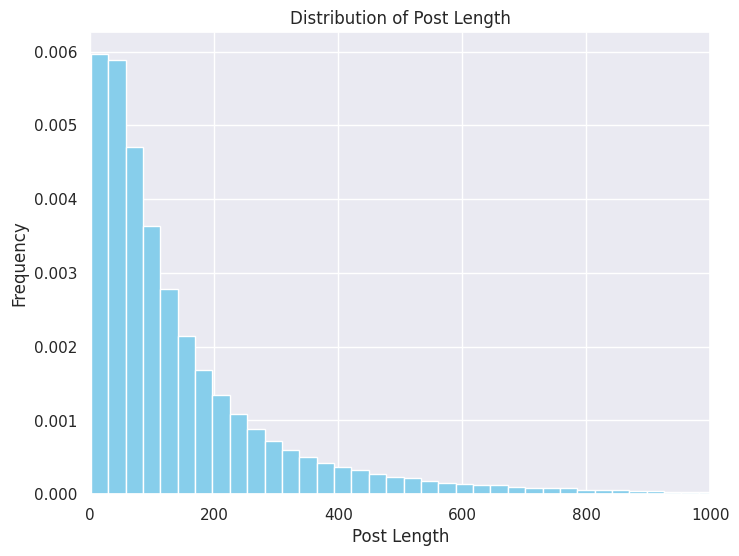

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Copy the DataFrame and calculate post lengths
df_s = df.copy()
df_s['post_length'] = df_s['body'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(df_s['post_length'], bins=700, color='skyblue', density=True)
plt.title('Distribution of Post Length')
plt.xlabel('Post Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.grid(True)
plt.show()


Creating another column to store mood of the post based on the polarity

In [64]:
# Create a new column called "sentiment_label"
dfa=df.copy()
dfa['sentiment_label'] = pd.cut(dfa['polarity'], [-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

# Print the DataFrame
dfa.head()

body        Date       id  \
0  Good god and apparently you work in software. ...  2020-05-23  frkm2w3   
1  Used to live near a Tune Up, was pretty happy ...  2020-05-23  frkm25i   
2  I hope this whole fiasco makes the general pub...  2020-05-23  frkm22r   
3       Thank you for asking the real question here.  2020-05-23  frkm1zl   
4  Restaurants can sell alcohol to go (liquor) wh...  2020-05-23  frklyq2   

    parent_id  score  polarity  subjectivity  fake_likelihood sentiment_label  
0  t1_frk44so    1.0  0.375000      0.475000         0.650000         Neutral  
1   t3_gp9g1d    1.0  0.257273      0.780000         0.462727         Neutral  
2   t3_gp9r8h    1.0  0.107500      0.429167         0.963333         Neutral  
3  t1_frj5uuk    1.0  0.200000      0.300000         1.000000         Neutral  
4   t3_gowk9h    1.0  0.000000      1.000000         0.500000         Neutral

In [65]:
# Create a new column called "sentiment_label"
stagea=stages.copy()
stagea['sentiment_label'] = pd.cut(stagea['polarity'], [-1, -0.5, 0.5, 1], labels=['Negative', 'Neutral', 'Positive'])

# Print the DataFrame
stagea.head()

author                                               body  \
0        helljess  Woman*. Iâ€™m sorry grown-up words and drugs o...   
1            TxEx        Fake news believers/Dan Patrick supporters.   
2      Roflattack  They won't pull you over for driving.  Don't g...   
3  insureventures             In Austin critical includes Pet shops.   
4       dyankee13                              Edibles! ðŸ”¥ðŸ”¥ðŸ”¥   

        Date       id   parent_id  score  Group    Stage  stage_num  polarity  \
0  3/24/2020  fleu096  t1_fleroki      1      6  stage 0          0   -0.0025   
1  3/24/2020  fletz0o   t3_foexxq      1      6  stage 0          0   -0.5000   
2  3/24/2020  flep3ja  t1_flel6mj      1      6  stage 0          0    0.0000   
3  3/24/2020  fleskl5   t3_fo6ynn      1      6  stage 0          0    0.0000   
4  3/24/2020  fleskkw  t1_flco8rq      1      6  stage 0          0    0.0000   

   subjectivity  fake_likelihood sentiment_label  
0         0.585           0.9175         Neutral  
1         1.000           1.0000        Negative  
2         0.000           1.5000         Neutral  
3         0.800           0.7000         Neutral  
4         0.000           1.5000         Neutral

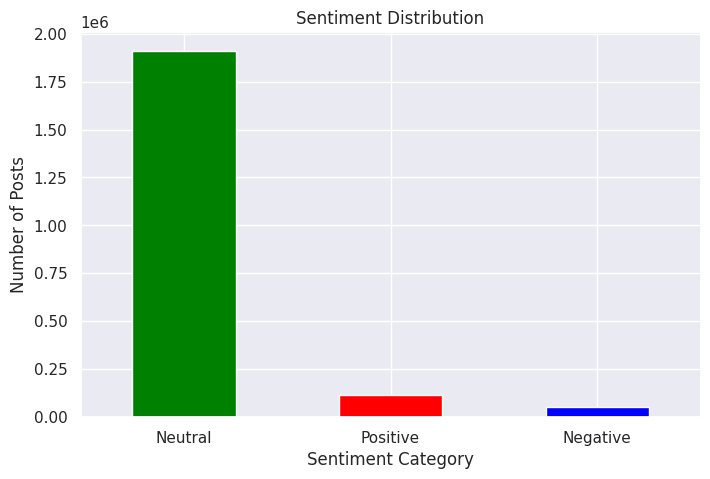

In [66]:
# Count the number of posts in each sentiment category
sentiment_counts = dfa['sentiment_label'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=0)
plt.show()


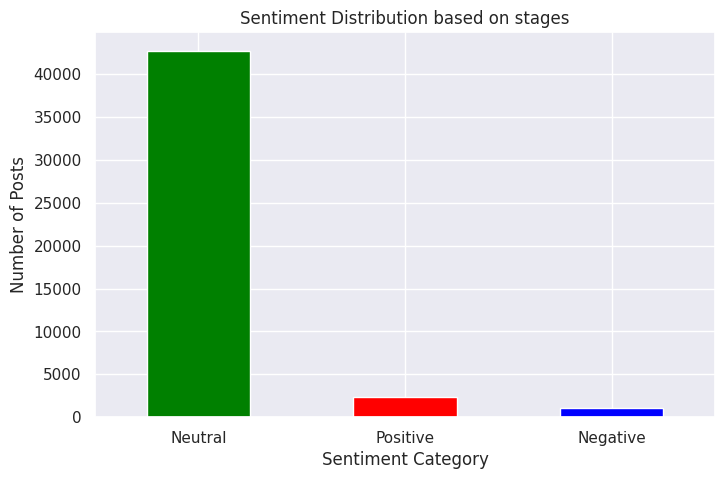

In [67]:
# Count the number of posts in each sentiment category
sentiment_counts = stagea['sentiment_label'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution based on stages")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=0)
plt.show()

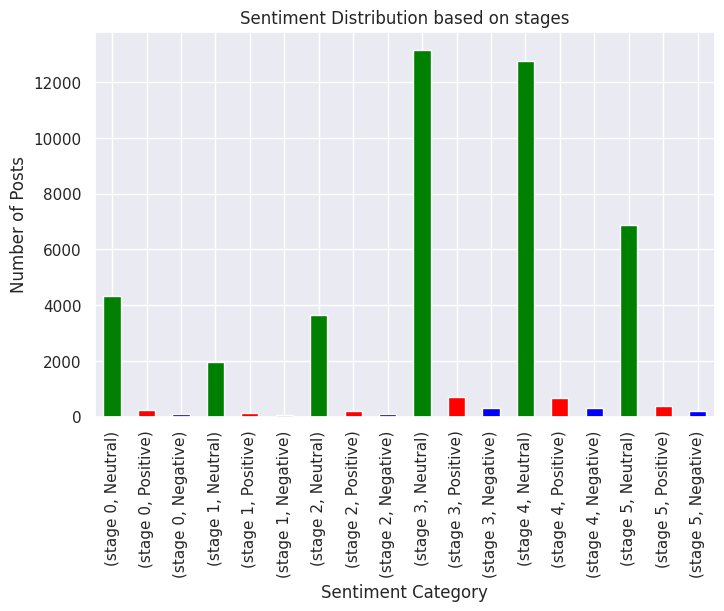

In [68]:
# Count the number of posts in each sentiment category
time_series = stagea.groupby('Stage')['sentiment_label'].value_counts()
#sentiment_counts = stagea['sentiment_label'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(8, 5))
time_series.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution based on stages")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Posts")
plt.xticks(rotation=90)
plt.show()

In [69]:
time_series = stagea.groupby('Stage')['sentiment_label'].value_counts()
time_series

Stage    sentiment_label
stage 0  Neutral             4346
         Positive             243
         Negative             108
stage 1  Neutral             1975
         Positive             122
         Negative              54
stage 2  Neutral             3647
         Positive             201
         Negative              97
stage 3  Neutral            13152
         Positive             697
         Negative             296
stage 4  Neutral            12751
         Positive             679
         Negative             331
stage 5  Neutral             6877
         Positive             401
         Negative             208
Name: sentiment_label, dtype: int64

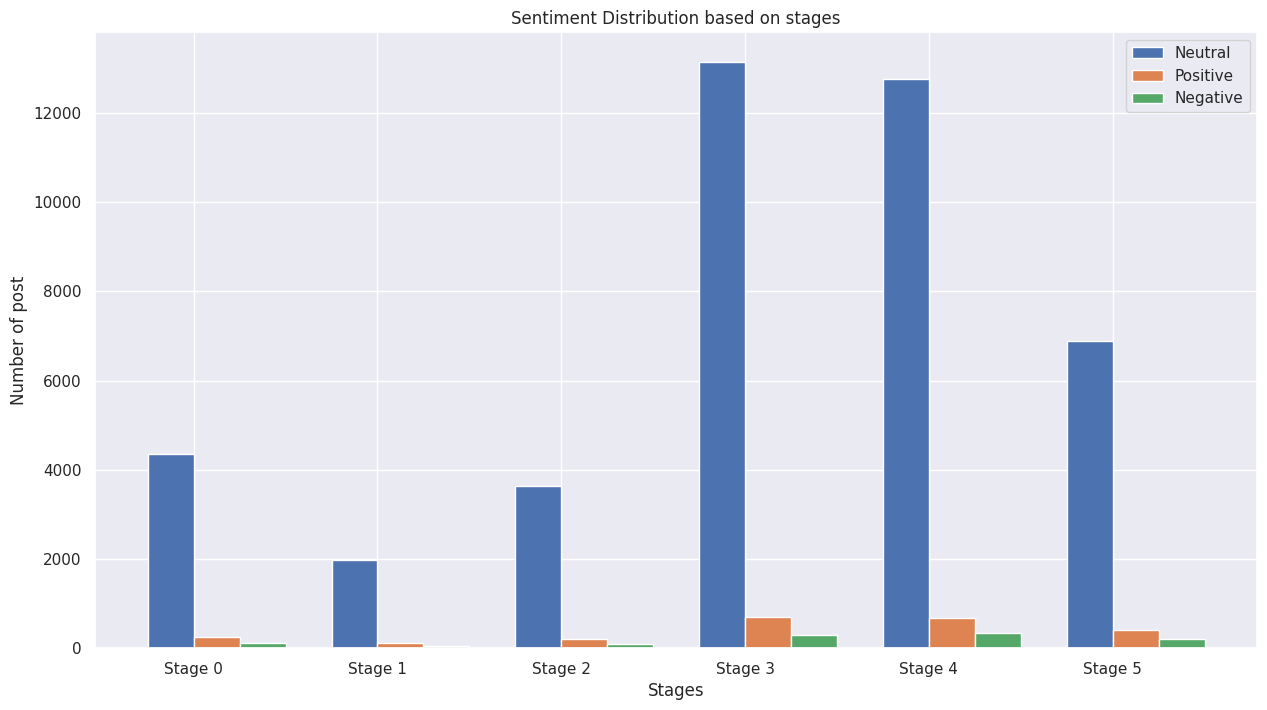

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
Stages = ['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5']
group_names = ['Neutral', 'Positive', 'Negative']
values = np.array([[4346, 1975, 3647, 13152, 12751, 6877], [243, 122, 201, 697, 679, 401], [108, 54, 97, 296, 331, 208]])

# Set the width of the bars
bar_width = 0.25

# Create the figure and axes
fig, ax = plt.subplots()

# Create the bars for each group
for i, group_name in enumerate(group_names):
    bar_positions = np.arange(len(Stages)) + i * bar_width
    bars = ax.bar(bar_positions, values[i], bar_width, label=group_name)

# Set the x-axis labels and title
ax.set_xticks(np.arange(len(Stages)) + bar_width / 2)
ax.set_xticklabels(Stages)
ax.set_xlabel('Stages')
ax.set_ylabel('Number of post')
ax.set_title('Sentiment Distribution based on stages')

# Add a legend
ax.legend()

# Show the plot
plt.show()


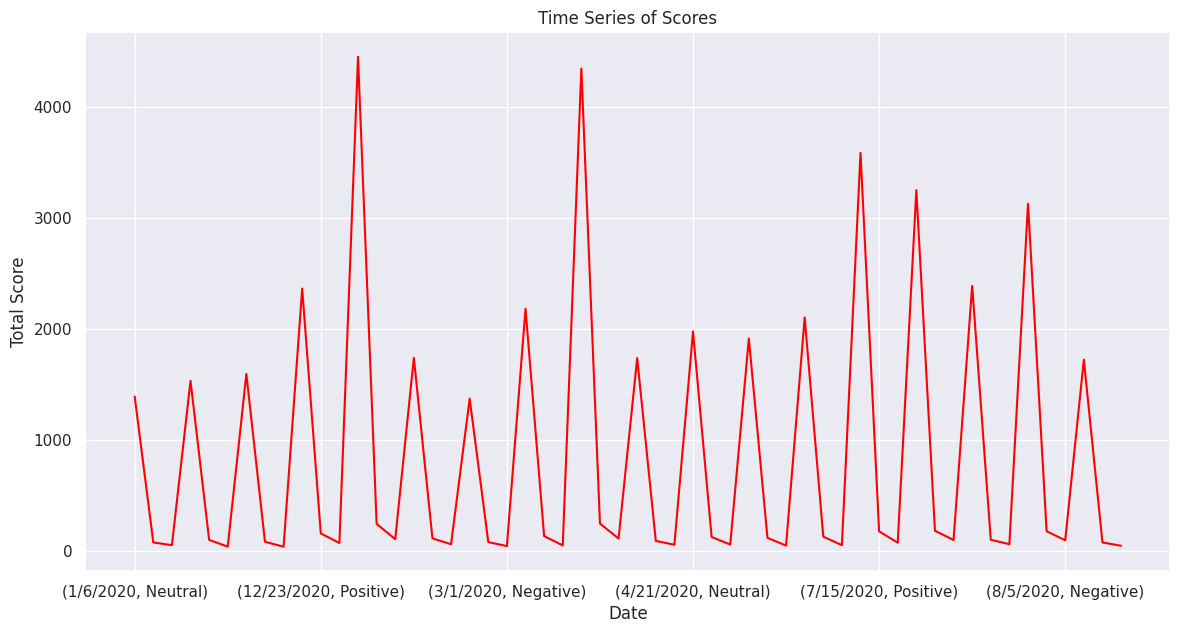

In [71]:
# Aggregate scores by date
time_series = stagea.groupby('Date')['sentiment_label'].value_counts()

# Plot the time series of scores
plt.figure(figsize=(14, 7))
time_series.plot(title='Time Series of Scores', color='red')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.grid(True)
plt.show()

In [72]:
dfa_1 = dfa.copy()

dfa_1['Date'] = pd.to_datetime(dfa_1['Date'])
dfa_1.set_index('Date', inplace=True)
# Calculate the daily mean of sentiment scores
dfa_1['polarity'] = dfa_1['polarity'].resample('D').mean()

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(dfa_1.index.values, dfa_1['polarity'].values, label='Daily Mean Sentiment Score', color='blue')
plt.title('Daily Mean Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Mean Sentiment Score')
plt.legend()
plt.show()


In [74]:
# Perform decomposition and time series analysis for daily mean scores
decomposition = sm.tsa.seasonal_decompose(dfa_1['polarity'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [75]:
plt.figure(figsize=(12, 6))
fig, axs = plt.subplots(4)
#fig.suptitle('Vertically stacked subplots')
axs[0].plot(dfa_1.index.values, dfa_1['polarity'].values, label='Original', color='blue')
axs[0].legend()
axs[1].plot(dfa_1.index.values, trend.values, label='Trend', color='red')
axs[1].legend()
axs[2].plot(dfa_1.index.values, residual.values, label='Residual', color='purple')
axs[2].legend()
axs[3].plot(dfa_1.index.values, seasonal.values, label='Seasonal', color='green')
axs[3].legend()

<Figure size 1200x600 with 0 Axes>

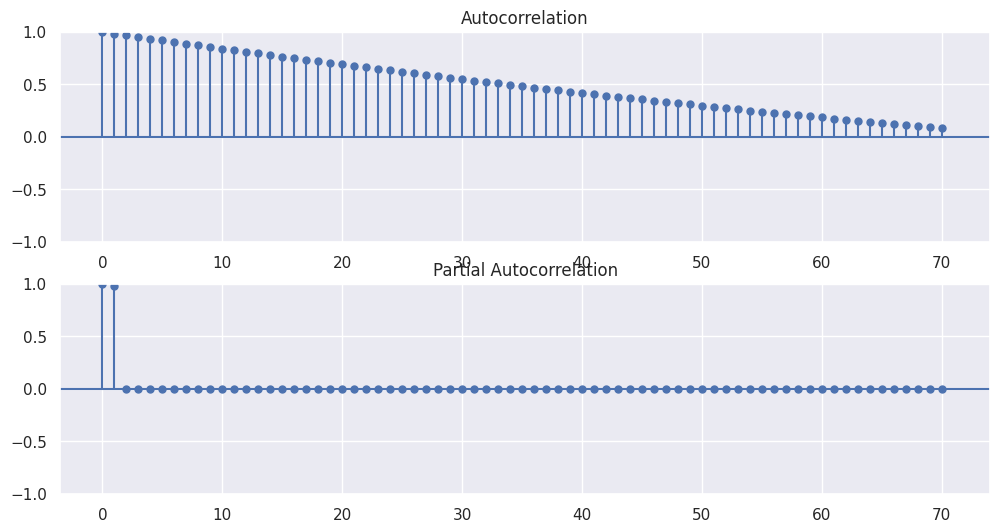

In [76]:
# Perform auto-correlation and partial auto-correlation analysis
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residual.dropna(), lags=70, ax=ax[0])
sm.graphics.tsa.plot_pacf(residual.dropna(), lags=70, ax=ax[1])
plt.show()

In [77]:
stagea_1 = stagea.copy()
# Perform decomposition and time series analysis for daily mean scores
decomposition = sm.tsa.seasonal_decompose(stagea_1['polarity'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

<Figure size 2000x1500 with 0 Axes>

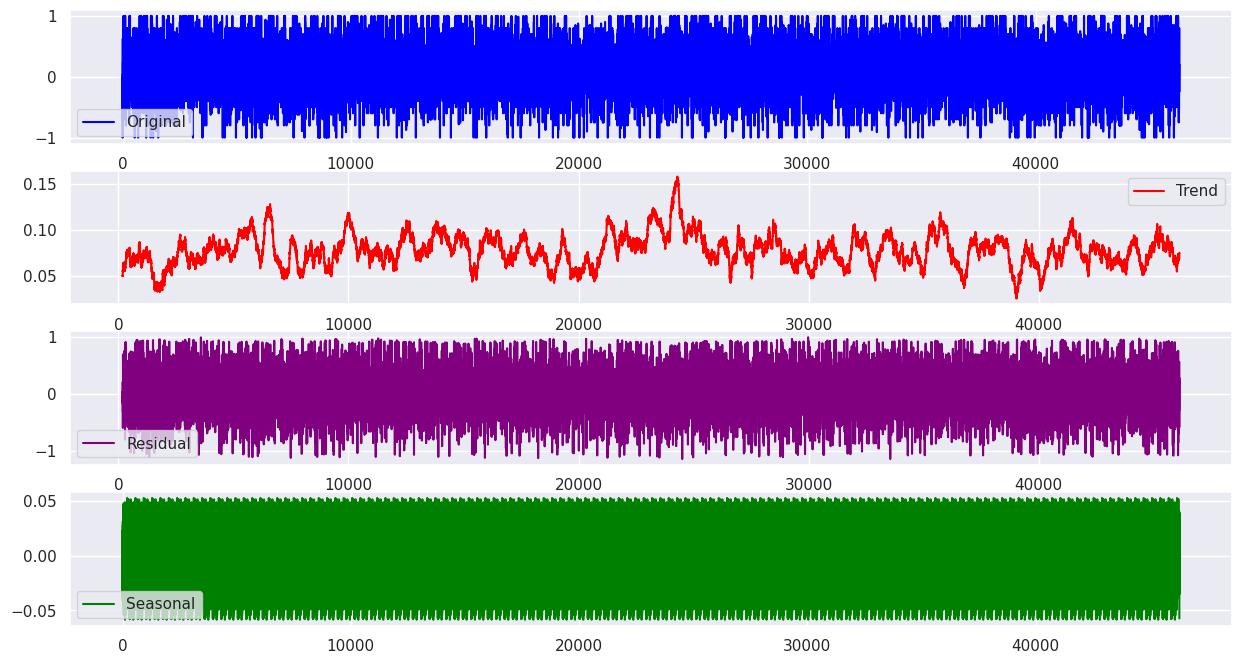

In [78]:
plt.figure(figsize=(20, 15))
fig, axs = plt.subplots(4)
#fig.suptitle('Vertically stacked subplots')
axs[0].plot(stagea_1.index.values, stagea_1['polarity'].values, label='Original', color='blue')
axs[0].legend()
axs[1].plot(stagea_1.index.values, trend.values, label='Trend', color='red')
axs[1].legend()
axs[2].plot(stagea_1.index.values, residual, label='Residual', color='purple')
axs[2].legend()
axs[3].plot(stagea_1.index.values, seasonal.values, label='Seasonal', color='green')
axs[3].legend()

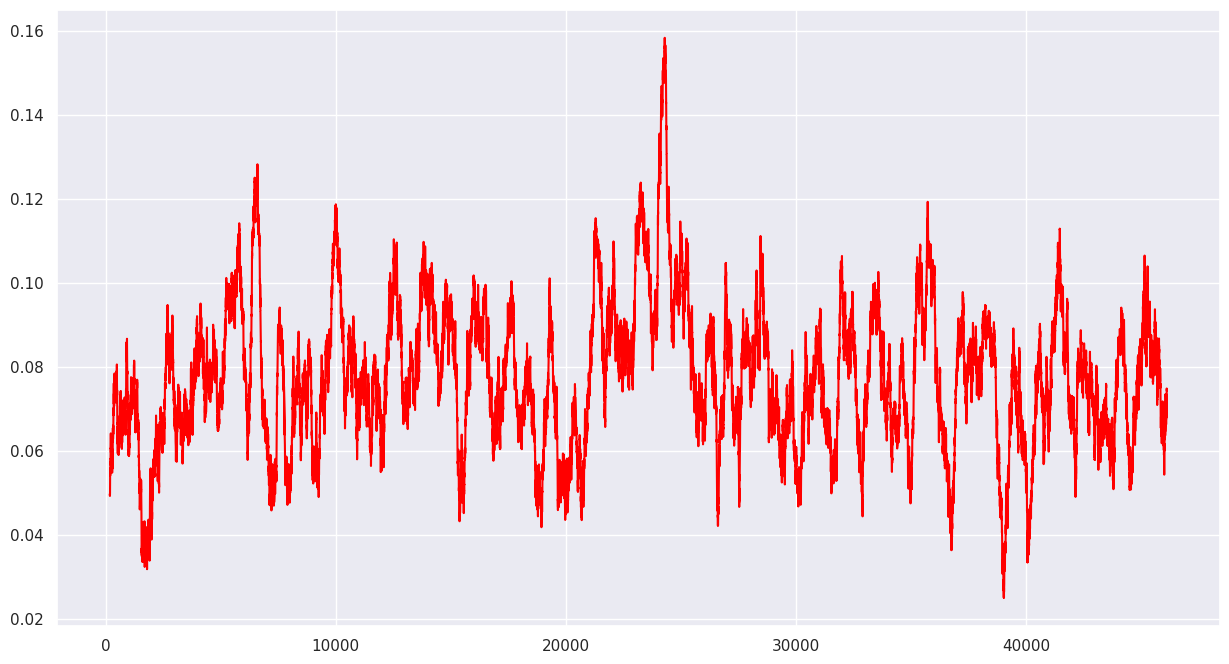

In [79]:
plt.plot(stagea_1.index, trend, label='Trend', color='red')

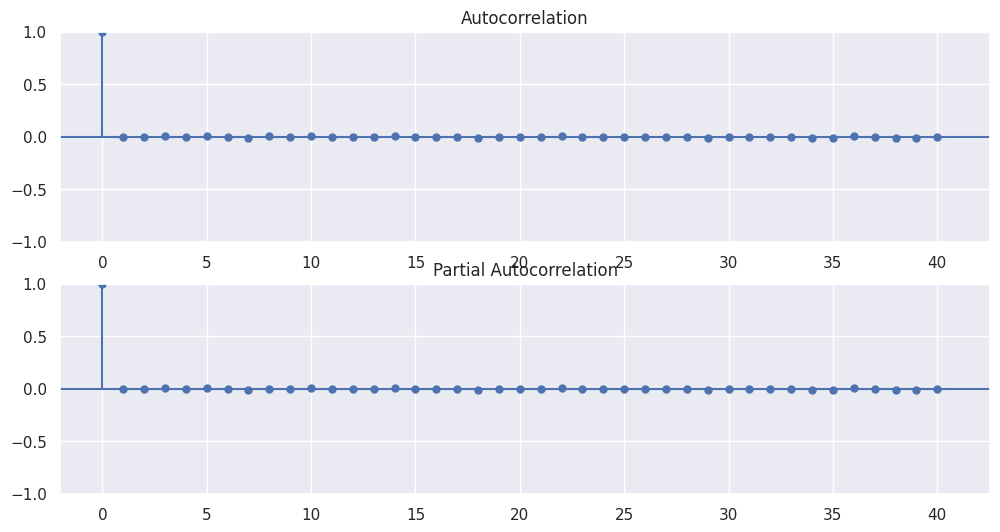

In [80]:
# Perform auto-correlation and partial auto-correlation analysis
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residual.dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(residual.dropna(), lags=40, ax=ax[1])
plt.show()

## Topic Modelling

*****
A type of statistical model for discovering the abstract "topics" that occur in a collection of documents. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.
*****

![](https://theintelligenceofinformation.files.wordpress.com/2016/12/topic-modeling-for-learning-analytics-researchers-lak15-tutorial-15-638.jpg)

### Popular topic modeling algorithms include Latent Semantic Analysis (LSA) a.k.a Latent Semantic Indexing , Hierarchical Dirichlet Process (HDP), Latent Dirichlet Allocation (LDA) and Non-negative Matrix factorization among which LDA has shown great results in practice and therefore widely adopted. We'll look at them all one by one if there is time. Lets get to it. 

#### Sub-Task 5.1: Preprocessing for Topic Modeling

In [81]:
st1= ['after', 'afterwards','again','against', 'all', 'almost','alone','along','already', 'also', 'although','always',
           'am','among','amongst','amoungst', 'amount', 'an','and','another','any','anyhow', 'anyone', 'anything',
           'anyway', 'anywhere','are','around', 'as', 'at','back', 'be','became','because', 'become','becomes',
           'becoming',   'been',  'before','beforehand','behind', 'being', 'below', 'beside','besides', 'between','beyond',
           'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt',
           'cry', 'de', 'describe', 'detail',  'do', 'done',  'down', 'due',  'during','each', 'eg', 'eight', 'either',
           'eleven', 'else','elsewhere','empty','enough', 'etc','even',  'ever', 'every', 'everyone', 'everything',
           'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former',
           'formerly',  'forty','found',  'four', 'from','front', 'full','further',  'get','give', 'go', 'had','has',
           'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon','hers',
           'herself',  'him', 'himself', 'his', 'how', 'however', 'hundred', 'i','ie', 'if', 'in','inc' 'indeed','interest',
           'into','is', 'it', 'its', 'itself', 'keep', 'last', 'latter',  'latterly', 'least', 'less', 'ltd', 'made',
           'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more',  'moreover',  'most',  'mostly',
           'move',   'much',  'must', 'my', 'myself','name','namely', 'neither', 'never', 'nevertheless', 'next',
           'nine',   'no', 'nobody', 'none', 'noone', 'nor','not', 'nothing', 'now', 'nowhere', 'of', 'off',
           'often', 'on', 'once', 'one','only','onto', 'or', 'other', 'others', 'otherwise', 'our',
           'ours', 'ourselves',  'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather',   're',  'same',
           'see', 'seem', 'seemed', 'seeming','seems',  'serious',  'several', 'she',  'should', 'show', 'side',
           'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone',   'something','sometime',
           'sometimes', 'somewhere', 'still', 'such','system',  'take', 'ten', 'than', 'that', 'the',
           'their',  'them',   'themselves',  'then', 'thence', 'there', 'thereafter', 'thereby',    'therefore',
           'therein',  'thereupon', 'these', 'they', 'thick', 'thin', 'third',  'this', 'those', 'though',  'three','through',
           'throughout', 'thru', 'thus',   'to', 'together', 'too', 'top', 'toward', 'towards',
           'twelve','twenty',  'two', 'un',  'under', 'until',   'up', 'upon',  'us', 'very', 'via', 'was', 'we',
           'well',   'were',  'what', 'whatever', 'when','whence', 'whenever','where', 'whereafter', 'whereas',
           'whereby', 'wherein', 'whereupon','wherever', 'whether', 'which','while', 'whither', 'who','whoever',
           'whole', 'whom',  'whose','why', 'will','with', 'within', 'without',  'would',  'yet', 'you','your',
           'yours', 'yourself', 'yourselves', 'com', 'www', 'https', 'gov', 'tag', 'wiki', 'said',
     'from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across']



In [82]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


# Tokenize the text
def tokenize(text):
    return text.split()

# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')).extend(st1)
    filtered_words = [word for word in text if word not in stop_words]
    return filtered_words

# Preprocess the text
dfa_1['body'] = dfa_1['body'].apply(simple_preprocess)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [84]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])
stop_words.extend(st1)

In [85]:
def remove_stopwords(text):
    filtered_words = [word for word in text if word not in stop_words]
    return ' '.join(filtered_words)

dfa_1['body'] = dfa_1['body'].apply(remove_stopwords)

In [86]:
dfa_1.head()

body       id  \
Date                                                                     
2020-05-23  good god apparently work software hope displea...  frkm2w3   
2020-05-23  used live near tune pretty happy especially mo...  frkm25i   
2020-05-23  hope fiasco makes general public aware lack pu...  frkm22r   
2020-05-23                         thank asking real question  frkm1zl   
2020-05-23  restaurants sell alcohol liquor gas stations s...  frklyq2   

             parent_id  score  polarity  subjectivity  fake_likelihood  \
Date                                                                     
2020-05-23  t1_frk44so    1.0  0.055067      0.475000         0.650000   
2020-05-23   t3_gp9g1d    1.0  0.055067      0.780000         0.462727   
2020-05-23   t3_gp9r8h    1.0  0.055067      0.429167         0.963333   
2020-05-23  t1_frj5uuk    1.0  0.055067      0.300000         1.000000   
2020-05-23   t3_gowk9h    1.0  0.055067      1.000000         0.500000   

           sentiment_label  
Date                        
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral

In [87]:
dfa_1['body'] = dfa_1['body'].apply(simple_preprocess)
dfa_1.head()

body       id  \
Date                                                                     
2020-05-23  [good, god, apparently, work, software, hope, ...  frkm2w3   
2020-05-23  [used, live, near, tune, pretty, happy, especi...  frkm25i   
2020-05-23  [hope, fiasco, makes, general, public, aware, ...  frkm22r   
2020-05-23                    [thank, asking, real, question]  frkm1zl   
2020-05-23  [restaurants, sell, alcohol, liquor, gas, stat...  frklyq2   

             parent_id  score  polarity  subjectivity  fake_likelihood  \
Date                                                                     
2020-05-23  t1_frk44so    1.0  0.055067      0.475000         0.650000   
2020-05-23   t3_gp9g1d    1.0  0.055067      0.780000         0.462727   
2020-05-23   t3_gp9r8h    1.0  0.055067      0.429167         0.963333   
2020-05-23  t1_frj5uuk    1.0  0.055067      0.300000         1.000000   
2020-05-23   t3_gowk9h    1.0  0.055067      1.000000         0.500000   

           sentiment_label  
Date                        
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral  
2020-05-23         Neutral

#### Sub-Task 5.2: Extracting Topics

In [88]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary of words
dictionary = corpora.Dictionary(dfa_1['body'])

# Create a corpus of bag-of-words vectors
corpus = [dictionary.doc2bow(text) for text in dfa_1['body']]

# Train an LDA model
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=10)

# Get the topic distribution for each document
topic_distribution = lda_model[corpus]

# Add the topic distribution to the DataFrame
dfa_1['topic_distribution'] = topic_distribution


In [89]:
dfa_1.index = range(1, len(dfa_1) + 1)

#### Display topic distribution

In [90]:
import random

# Select a random subset of documents (e.g., 10 documents) for visualization
num_documents_to_display = 5
sample_documents = random.sample(range(len(dfa_1)), num_documents_to_display)

for document_index in sample_documents:
    topic_probabilities = dfa_1.loc[document_index, 'topic_distribution']
    print(f"Document {document_index + 1}:")
    for topic_id, probability in topic_probabilities:
        print(f"Topic {topic_id + 1}: {probability:.2f}")

Document 1552475:
Topic 3: 0.41
Topic 5: 0.23
Topic 9: 0.22
Topic 10: 0.10
Document 713027:
Topic 1: 0.01
Topic 2: 0.01
Topic 3: 0.17
Topic 4: 0.01
Topic 5: 0.27
Topic 6: 0.01
Topic 7: 0.14
Topic 8: 0.01
Topic 9: 0.35
Topic 10: 0.01
Document 292123:
Topic 1: 0.03
Topic 2: 0.03
Topic 3: 0.03
Topic 4: 0.03
Topic 5: 0.27
Topic 6: 0.29
Topic 7: 0.03
Topic 8: 0.03
Topic 9: 0.03
Topic 10: 0.26
Document 990263:
Topic 1: 0.03
Topic 2: 0.03
Topic 3: 0.03
Topic 4: 0.03
Topic 5: 0.37
Topic 6: 0.03
Topic 7: 0.03
Topic 8: 0.37
Topic 9: 0.03
Topic 10: 0.03
Document 878415:
Topic 1: 0.03
Topic 2: 0.03
Topic 3: 0.03
Topic 4: 0.03
Topic 5: 0.37
Topic 6: 0.03
Topic 7: 0.03
Topic 8: 0.37
Topic 9: 0.03
Topic 10: 0.03


In [91]:
import random

# Select a random sample of documents
num_documents_to_display = 5  # Change this to the desired number of documents
sample_documents = random.sample(range(len(dfa_1)), num_documents_to_display)

# Print the topics and their probabilities for the selected documents
for document_index in sample_documents:
    topic_probabilities = lda_model[corpus[document_index]]
    print(f"Document {document_index + 1}:")
    for topic_id, probability in topic_probabilities:
        print(f"Topic {topic_id + 1}: {probability:.2f}")


Document 1329095:
Topic 1: 0.03
Topic 2: 0.03
Topic 3: 0.03
Topic 4: 0.70
Topic 5: 0.03
Topic 6: 0.03
Topic 7: 0.03
Topic 8: 0.03
Topic 9: 0.03
Topic 10: 0.03
Document 1853040:
Topic 1: 0.02
Topic 2: 0.02
Topic 3: 0.02
Topic 4: 0.82
Topic 5: 0.02
Topic 6: 0.02
Topic 7: 0.02
Topic 8: 0.02
Topic 9: 0.02
Topic 10: 0.02
Document 151609:
Topic 1: 0.18
Topic 3: 0.42
Topic 9: 0.11
Topic 10: 0.24
Document 882418:
Topic 1: 0.02
Topic 2: 0.18
Topic 3: 0.02
Topic 4: 0.02
Topic 5: 0.02
Topic 6: 0.02
Topic 7: 0.02
Topic 8: 0.02
Topic 9: 0.02
Topic 10: 0.68
Document 1359916:
Topic 5: 0.22
Topic 7: 0.19
Topic 9: 0.33
Topic 10: 0.23


In [92]:
import random

# Select a random subset of documents (e.g., 10 documents) for visualization
num_documents_to_display = 5
sample_documents = random.sample(range(len(dfa_1)), num_documents_to_display)

for document_index in sample_documents:
    topic_probabilities = dfa_1.loc[document_index, 'topic_distribution']
    print(f"Document {document_index + 1}:")
    for topic_id, probability in topic_probabilities:
        print(f"Topic {topic_id + 1}: {probability:.2f}")

Document 1324729:
Topic 4: 0.28
Topic 5: 0.47
Topic 10: 0.19
Document 393954:
Topic 1: 0.28
Topic 2: 0.03
Topic 3: 0.03
Topic 4: 0.03
Topic 5: 0.03
Topic 6: 0.03
Topic 7: 0.03
Topic 8: 0.03
Topic 9: 0.03
Topic 10: 0.52
Document 1011093:
Topic 1: 0.13
Topic 4: 0.07
Topic 5: 0.15
Topic 6: 0.17
Topic 7: 0.32
Topic 10: 0.12
Document 396069:
Topic 1: 0.05
Topic 2: 0.05
Topic 3: 0.55
Topic 4: 0.05
Topic 5: 0.05
Topic 6: 0.05
Topic 7: 0.05
Topic 8: 0.05
Topic 9: 0.05
Topic 10: 0.05
Document 289150:
Topic 1: 0.01
Topic 2: 0.01
Topic 3: 0.26
Topic 4: 0.38
Topic 5: 0.26
Topic 6: 0.01
Topic 7: 0.01
Topic 8: 0.01
Topic 9: 0.01
Topic 10: 0.01


Dividing data into years

In [93]:
df_t = dfa.copy()
df_t['Date'] = pd.to_datetime(df_t['Date'])

specific_year = 2019

# Subset the data based on the specific year
df_2019 = df_t[df_t['Date'].dt.year == specific_year]
df_2019.shape

(527857, 9)

In [94]:
specific_year = 2020

# Subset the data based on the specific year
df_2020 = df_t[df_t['Date'].dt.year == specific_year]
df_2020.shape

(695477, 9)

In [95]:
specific_year = 2021

# Subset the data based on the specific year
df_2021 = df_t[df_t['Date'].dt.year == specific_year]
df_2021.shape

(862432, 9)

bg_rows = np.random.choice(bg.index.values, 750)
bg_data = bg.ix[bg_rows]

tg_rows = np.random.choice(tg.index.values, 750)
tg_data = tg.ix[tg_rows]

eg_rows = np.random.choice(eg.index.values, 750)
eg_data = eg.ix[eg_rows]

mg_rows = np.random.choice(mg.index.values, 750)
mg_data = mg.ix[mg_rows]

### Selecting sample rows from all years so computations are quicker. 

In [96]:
df_2019_data = df_2019.loc[np.random.choice(df_2019.index, 20000)]
df_2020_data = df_2020.loc[np.random.choice(df_2020.index, 20000)]
df_2021_data = df_2021.loc[np.random.choice(df_2021.index, 20000)]

In [97]:
result = pd.concat([df_2019_data, df_2020_data, df_2021_data], ignore_index=True)

result.head()

body       Date       id  \
0  The Austin mods established the rules on here.... 2019-09-05  ez6wnqb   
1  Your own source, you fucking moron:\n\nhttps:/... 2019-05-25  eoswvla   
2        It's basically a reversed Mexican Halloween 2019-08-08  ewddpr8   
3  He probably doesn’t have a girlfriend.  Just g... 2019-05-05  emknsmq   
4  Cool, thanks. He's got some interesting ideas ... 2019-02-21  egyr29m   

    parent_id  score  polarity  subjectivity  fake_likelihood sentiment_label  
0  t1_ez6v62m    1.0  0.157143      0.272143         1.070714         Neutral  
1  t1_eoswh3u   12.0 -0.100000      1.000000         0.600000         Neutral  
2  t1_ew90pe7    1.0  0.000000      0.000000         1.500000         Neutral  
3  t1_emkke50    5.0  0.000000      0.000000         1.500000         Neutral  
4  t1_egypdzp    1.0  0.387500      0.559722         0.552778         Neutral

In [98]:
title = result['body']
category = result['sentiment_label']

<a id='lsa'></a>

# Latent Semantic Analysis

![](https://nlp.stanford.edu/IR-book/html/htmledition/img1822.png)

Latent Semantic Analysis (LSA) is a mathematical method that tries to bring out latent relationships within a collection of documents on to a lower dimensional space. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per paragraph (rows represent unique words and columns represent each paragraph) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns.  Rather than looking at each document isolated from the others it looks at all the documents as a whole and the terms within them to identify relationships.

Singular value decomposition can be used to solve the low-rank matrix approximation problem. We then derive from it an application to approximating term-document matrices. We invoke the following three-step procedure to this end:
***
 * Given $C$, construct its SVD in the form $C=U\Sigma V^T$.
 * Derive from $\Sigma$ the matrix $\Sigma_k$ formed by replacing by zeros the $r-k$ smallest singular values on the diagonal of $\Sigma$.
 * Compute and output $C_k$= $U\Sigma_k V^T$ as the rank-$k$ approximation to $C$.;
​
Where C is the term-document matrix and $U$, $\Sigma$ and $V^T$ are SVD computed matrices.
***

> > **Done with theory, on to Python now!  For LSI,  i'll be using scikit learn module**
​
**Importing modules from scikit learn and countvector-izing them first. ** 
​
**In Scikit learn, Dimensionality reduction for LSA is done using truncated SVD (aka LSA).**

In [99]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])
stop_words.extend(st1)

In [100]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 10

# Converting the document to a matrix of token counts

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(title)
 
# Build a Latent Semantic Indexing Model using SVD

lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)

(60000, 10)


In [101]:
def print_topics(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(feature_names[i], topic[i])
               for i in topic.argsort()[:-top_n - 1:-1]])

print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

LSI Model:
Topic 0:
[('https', 0.41846559803738953), ('austin', 0.4064914021453979), ('com', 0.38112228141775245), ('www', 0.3025993709008551), ('people', 0.21845068407811277), ('reddit', 0.15223901219641167), ('just', 0.1487927299784168), ('amp', 0.13939261529286553), ('like', 0.12966944412836193), ('don', 0.113541456314825)]
Topic 1:
[('com', 0.3278199586309936), ('https', 0.31413385288556916), ('www', 0.25093378253964044), ('reddit', 0.1329246406914609), ('message', 0.10076354799280553), ('amp', 0.08995389841864283), ('http', 0.06677836734953269), ('comments', 0.05102103770481821), ('news', 0.04840626357718557), ('compose', 0.041543575560717104)]
Topic 2:
[('https', 0.30670224189532164), ('church', 0.3009348560130377), ('unt', 0.2388107331872587), ('edu', 0.2370482962063925), ('ark', 0.23290507743187522), ('metapth', 0.2328572128175313), ('texashistory', 0.2328572128175313), ('david', 0.23215791672007588), ('photograph', 0.21897022203778996), ('people', 0.1791713251593314)]
Topic 3:

In [102]:
def get_topics(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    topics = []

    for idx, topic in enumerate(model.components_):
        topic_words = [(feature_names[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        topics.append({'Topic': idx, 'Words': [word for word, _ in topic_words]})

    return pd.DataFrame(topics)

# Example usage:
topics_df = get_topics(lsi_model, vectorizer)
print(topics_df)


   Topic                                              Words
0      0  [https, austin, com, www, people, reddit, just...
1      1  [com, https, www, reddit, message, amp, http, ...
2      2  [https, church, unt, edu, ark, metapth, texash...
3      3  [austin, water, church, david, unt, metapth, t...
4      4  [water, use, boil, notice, https, www, com, dr...
5      5  [reddit, message, just, amp, like, church, com...
6      6  [just, like, pet, animal, don, shelter, church...
7      7  [said, city, austin, texas, new, council, year...
8      8  [like, amp, don, looks, know, message, feel, s...
9      9  [amp, don, time, utm, said, pet, city, animal,...


In [103]:
import pandas as pd

def get_topics(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    topics = []

    for idx, topic in enumerate(model.components_):
        topic_words = [(feature_names[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        topics.append({'Topic': idx, 'Words': [word for word, _ in topic_words], 'Probabilities': [prob for _, prob in topic_words]})

    return pd.DataFrame(topics)

# Example usage:
topics_df = get_topics(lsi_model, vectorizer)
topics_df


Topic                                              Words  \
0      0  [https, austin, com, www, people, reddit, just...   
1      1  [com, https, www, reddit, message, amp, http, ...   
2      2  [https, church, unt, edu, ark, metapth, texash...   
3      3  [austin, water, church, david, unt, metapth, t...   
4      4  [water, use, boil, notice, https, www, com, dr...   
5      5  [reddit, message, just, amp, like, church, com...   
6      6  [just, like, pet, animal, don, shelter, church...   
7      7  [said, city, austin, texas, new, council, year...   
8      8  [like, amp, don, looks, know, message, feel, s...   
9      9  [amp, don, time, utm, said, pet, city, animal,...   

                                       Probabilities  
0  [0.41846559803738953, 0.4064914021453979, 0.38...  
1  [0.3278199586309936, 0.31413385288556916, 0.25...  
2  [0.30670224189532164, 0.3009348560130377, 0.23...  
3  [0.53368940819878, 0.318624763019749, 0.201919...  
4  [0.8166573065140214, 0.15926852510315503, 0.15...  
5  [0.3510583305493665, 0.28932256793212, 0.26275...  
6  [0.37469795258578437, 0.26283852253813683, 0.1...  
7  [0.24943989732309751, 0.2347007215758831, 0.16...  
8  [0.6906095544397506, 0.14664096675644564, 0.07...  
9  [0.7981643102537883, 0.11530773267884566, 0.10...

### above are the topics by the LSI model. 

In [104]:
from sklearn.manifold import TSNE
# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

### Lets now visualise the LSI model and see the words and documents that are close to each other according to the model

### Documents

In [105]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

svd = TruncatedSVD(n_components=100)
documents_2d = svd.fit_transform(data_vectorized)
 
dfdf = pd.DataFrame(columns=['x', 'y', 'document'])
dfdf['x'], dfdf['y'], dfdf['document'] = documents_2d[:,0], documents_2d[:,1], range(len(result))
 
source = ColumnDataSource(ColumnDataSource.from_df(dfdf))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(width=600, height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Loading BokehJS ...

### The Inference from the plot above is that similar documents are plotted close by in a low dimensional space. Same with words(although not the objective here) shown below, 

### Words

<a id='lda'></a>

# Latent Dirichlet Allocation

### Corpus - Document - Word : Topic Generation

***
**Is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.**
***

 <hr>
           
           LSI examines the words used in a document and looks for their relationships with other words. LSI allows a system to determine the kind of words that a document might be relevant for, even if they are not actually used on the document itself.  But having content that is full of words that have relationships with each other, you are strengthening the document for all of those words.
        
           LDA is a significant extension of LSI.  Words are grouped into topics.  They can exist in more than one topic, in fact most do.  LDA tackles ambiguity by comparing a document to two topics and determining which topic is closer to the document, across all combinations of topics which seem broadly relevant. In doing so, LDA helps to determine which documents are most relevant to which topics.
<hr/>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Latent_Dirichlet_allocation.svg/593px-Latent_Dirichlet_allocation.svg.png)

***
α is the parameter of the Dirichlet prior on the per-document topic distributions,
β is the parameter of the Dirichlet prior on the per-topic word distribution,
$ \theta _{m}$ is the topic distribution for document m,
$\varphi _{k}$ is the word distribution for topic k,
$z_{mn}$ is the topic for the n-th word in document m, and
$w_{mn}$ is the specific word.
​
***
The fact that W is grayed out means that words $\displaystyle w_{ij}$ are the only observable variables, and the other variables are latent variables. A sparse Dirichlet prior can be used to model the topic-word distribution, following the intuition that the probability distribution over words in a topic is skewed, so that only a small set of words have high probability. The resulting model is the most widely applied variant of LDA today. The plate notation for this model is shown below, where $\displaystyle K$  denotes the number of topics and $\displaystyle \varphi _{1},\dots ,\varphi _{K}$ are $\displaystyle V$-dimensional vectors storing the parameters of the Dirichlet-distributed topic-word distributions ( $\displaystyle V$ is the number of words in the vocabulary).
​
It is helpful to think of the entities represented by $\displaystyle \theta$ and $\displaystyle \varphi$ as matrices created by decomposing the original document-word matrix that represents the corpus of documents being modeled. In this view, $\displaystyle \theta$  consists of rows defined by documents and columns defined by topics, while $\displaystyle \varphi$ consists of rows defined by topics and columns defined by words. Thus, $\displaystyle \varphi _{1},\dots ,\varphi _{K}$ refers to a set of rows, or vectors, each of which is a distribution over words, and $\displaystyle \theta _{1},\dots ,\theta _{M}$ refers to a set of rows, each of which is a distribution over topics.
​
***

![](https://upload.wikimedia.org/wikipedia/commons/4/4d/Smoothed_LDA.png)

**LDA assumes that each document in a corpus contains a mix of topics that are found throughout the entire corpus. The topic structure is hidden - we can only observe the documents and words, not the topics themselves. Because the structure is hidden (also known as latent), this method seeks to infer the topic structure given the known words and documents.**

### LDA Document Structure

### LDA represents documents as mixtures of topics that spit out words with certain probabilities. It assumes that documents are produced in the following fashion: when writing each document, you

***
* Decide on the number of words N the document will have.
* Choose a topic mixture for the document (according to a Dirichlet probability distribution over a fixed set of K topics). 
* Generate each word in the document by:
    *  First picking a topic.
    * Then using the topic to generate the word itself (according to the topic’s multinomial distribution).
    * Assuming this generative model for a collection of documents, LDA then tries to backtrack from the documents to find a set of topics that are likely to have generated the collection.
***

## Now that we saw the theory aspects and the maths behind, lets see how to do it in python,

### Convert to list so we can do some pre-processing

In [106]:
# Convert to list
dfas = result.body.values.tolist()

dfas = [re.sub('\S*@\S*\s?', '', sent) for sent in dfas]

# Remove new line characters
dfas = [re.sub('\s+', ' ', sent) for sent in dfas]

# Remove distracting single quotes
dfas = [re.sub("\'", "", sent) for sent in dfas]

pprint(dfas[:3])

['The Austin mods established the rules on here. Disagree with them all you '
 'want, but this will not be posted. This is not a political subreddit, there '
 'are many political subreddits to protest things like this (yes, this falls '
 'under politics). Austin is not one of them. I am not going to continue to '
 'answer these same questions. The rules are posted on the sidebar to the '
 'right and here: https://www.reddit.com/r/Austin/wiki/rulesandmoderating',
 'Your own source, you fucking moron: '
 'https://en.wikipedia.org/wiki/Transgender#Drag_kings_and_queens',
 'Its basically a reversed Mexican Halloween']


In [107]:
dfas = [re.sub("-", " ", sent) for sent in dfas]
dfas = [re.sub(":", "", sent) for sent in dfas]

### All punctuations need to be removed, so lets write a function for that and we'll use the gensim package for that. deacc=TRUE does that. 

In [108]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(dfas))

### N-gram models

### Creating Bigram and Trigram Models

### What are they? 

### Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Gensim's Phrases method helps us with that. 

In [109]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### We need to apply the bigrams, trigrams and lemmatize the set of documents we are working with.

###  mm lemmatize ? ok  It is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

### To do that, lets create few functions. 

In [110]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Applying the custom functions to our dataset

In [111]:
# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### As we saw in the definition above, converting our document set into a document-term matrix.

In [112]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Readable format of corpus (term-frequency)

In [113]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('want', 1),
  ('city', 1),
  ('cloud', 1),
  ('fuck', 1),
  ('literally', 1),
  ('log', 1),
  ('people', 1),
  ('yell', 1)]]

### Building the LDA model

In [114]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### Now that the model is built, lets print the Keyword in the 10 topics

In [115]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.059*"people" + 0.023*"want" + 0.020*"city" + 0.016*"try" + 0.015*"right" '
  '+ 0.013*"state" + 0.012*"post" + 0.012*"help" + 0.011*"happen" + '
  '0.010*"tell"'),
 (1,
  '0.043*"go" + 0.041*"think" + 0.032*"make" + 0.029*"m" + 0.027*"thing" + '
  '0.023*"look" + 0.020*"sure" + 0.016*"point" + 0.014*"car" + 0.014*"drive"'),
 (2,
  '0.028*"re" + 0.021*"bad" + 0.021*"thank" + 0.018*"pretty" + 0.016*"covid" + '
  '0.015*"new" + 0.015*"move" + 0.014*"leave" + 0.013*"power" + '
  '0.013*"number"'),
 (3,
  '0.025*"get" + 0.023*"time" + 0.023*"know" + 0.022*"s" + 0.020*"good" + '
  '0.018*"work" + 0.017*"need" + 0.015*"way" + 0.015*"day" + 0.014*"really"'),
 (4,
  '0.023*"year" + 0.020*"lot" + 0.019*"say" + 0.017*"come" + 0.016*"ve" + '
  '0.015*"pay" + 0.014*"home" + 0.013*"feel" + 0.013*"mean" + 0.012*"vaccine"')]


### Right, now that the LDA model is built, there has to be a metric to evaluate how good the model is. Lets compute that to check how good it is. 


### There are 2 such metrics. 

### 1)   Perplexity -  Is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of k, you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents. - Lower the better.
### 2)  Coherence Score - Is defined as the average / median of the pairwise word-similarity scores of the words in the topic - Higher the better.
                          

In [116]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.400349853114259

Coherence Score:  0.5936335700282044


> ** From the model we created, lets look at the most salient terms under each topic that contributes to it the most** 

In [119]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.399493 -0.025239       1        1  27.395251
0     -0.147921 -0.308045       2        1  20.986943
4     -0.107941  0.320008       3        1  19.778518
1     -0.072557 -0.001487       4        1  17.536362
2     -0.071074  0.014764       5        1  14.302926, topic_info=        Term         Freq        Total Category  logprob  loglift
71    people  8456.000000  8456.000000  Default  30.0000  30.0000
6         go  5148.000000  5148.000000  Default  29.0000  29.0000
61     think  4931.000000  4931.000000  Default  28.0000  28.0000
58      make  3793.000000  3793.000000  Default  27.0000  27.0000
29       get  4789.000000  4789.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1051    info   523.480303   524.298437   Topic5  -5.2331   1.9431
519   street   519.937224   520.750367   Topic5  -5.2399   1.9431
264    death   504.842095   505.651371   Topic5  -5.2694   1.9431
672   matter   486.321780   487.136941   Topic5  -5.3068   1.9430
40     thank  2062.271755  2246.693920   Topic5  -3.8621   1.8591

[184 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
988       3  0.999126      able
584       3  0.999653  actually
648       5  0.998794       add
197       4  0.998918     agree
533       3  0.999429      area
...     ...       ...       ...
571       1  0.999296      week
147       4  0.999538      well
236       1  0.999730      work
2074      4  0.999474     wrong
307       3  0.999624      year

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])